Text Mining: Corporate Culture Analysis 
-------------------------------------

# 1. Collecting Text Data from Job Planet
# 2. Frequency Analysis 
 ### (1) Simple Frequency from Total Text  
 ### (2) Frequency based on Morphemes  
 ### (3) Frequency based on Keywords
 
# 3. Hierarchical Clustering by Keywords
# 4. Network Analysis




In [1]:
from selenium import webdriver
import time
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [ ]:
browser = webdriver.Chrome('C:\\Users\\an-user\\Downloads\\chromedriver.exe')
browser.implicitly_wait(5)
browser.get('https://www.jobplanet.co.kr/')

# Collecting Raw Text Data

In [27]:
##list for raw data
title_list = []
advantage_list = []
drawback_list = []
opinion_list = []
personal_info = []
promotion, welfareandsalary, worklifebalance, corporateculture, executives = [], [],[],[],[]

##crawling data from Jobplanet
for board_number in range(1, 25):
    browser.get("https://www.jobplanet.co.kr/companies/60632/reviews/%EC%9C%84%EB%A9%94%ED%94%84?page=&page=" + str(board_number))
    contents = browser.find_elements_by_css_selector('div.content_wrap')
    clean_contents = contents[:2] + contents[4:]

    for i in range(len(clean_contents)):
        ##personal_info and text info
        text = clean_contents[i].text.split('\n')
        personal_info.append(text[:text.index('평점')])
        title_list.append(' '.join(str(text[12:text.index('장점')])))
        advantage_list.append(' '.join(str(text[text.index('장점') + 1 : text.index('단점')])))
        drawback_list.append(' '.join(str(text[text.index('단점') + 1 : text.index('경영진에 바라는 점')])))
        opinion_list.append(' '.join(str(text[text.index('경영진에 바라는 점') + 1 : -5])))
    
        ##score info
        html = clean_contents[i].get_attribute('outerHTML')
        attributes = str(BeautifulSoup(html, 'lxml')).split('\n')
        promotion.append(re.findall(r'\d+', attributes[21]))
        welfareandsalary.append(re.findall(r'\d+', attributes[27]))
        worklifebalance.append(re.findall(r'\d+', attributes[33]))
        corporateculture.append(re.findall(r'\d+', attributes[39]))
        executives.append(re.findall(r'\d+', attributes[45]))

        
##Converting list into dataframe
personal_info_df = pd.DataFrame(personal_info, columns = ['info'])
title_df = pd.DataFrame(title_list, columns = ['title'])
advantage_df = pd.DataFrame(advantage_list, columns = ['advantage'])
drawback_df = pd.DataFrame(drawback_list, columns = ['drawback'])
opinion_df = pd.DataFrame(opinion_list, columns = ['opinion'])
promotion_score = pd.DataFrame(promotion, columns = ['promotion'])
welfareandsalary_score = pd.DataFrame(welfareandsalary, columns = ['welfaresalary'])
worklifebalance_score = pd.DataFrame(worklifebalance, columns = ['worklifebalance'])
corporateculture_score = pd.DataFrame(corporateculture, columns = ['culture'])
executives_score = pd.DataFrame(executives, columns = ['executives'])

## Merging Data
df = pd.concat([personal_info_df,
                     title_df,
                     advantage_df,
                     drawback_df,
                     opinion_df,
                     promotion_score,
                     welfareandsalary_score,
                     worklifebalance_score,
                     corporateculture_score,
                     executives_score], axis=1)


# Cleaning DataFrame

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
info               120 non-null object
title              120 non-null object
advantage          120 non-null object
drawback           120 non-null object
opinion            120 non-null object
promotion          120 non-null object
welfaresalary      120 non-null object
worklifebalance    120 non-null object
culture            120 non-null object
executives         120 non-null object
dtypes: object(10)
memory usage: 9.5+ KB


In [30]:
df['total'] = ""
df['date'] = ''
df['region'] = ''
df['workingstatus'] = ''
df['department'] = ''
for i in range(len(df)):
    ##converting 0 to 100 score scale into 1 to 5 score scale. 
    df['promotion'][i] = int(df['promotion'][i])/20
    df['welfaresalary'][i] = int(df['welfaresalary'][i])/20
    df['worklifebalance'][i] = int(df['worklifebalance'][i])/20
    df['culture'][i] = int(df['culture'][i])/20
    df['executives'][i] = int(df['executives'][i])/20
    df['total'][i] = (df['executives'][i] + df['culture'][i] + df['worklifebalance'][i] + df['welfaresalary'][i] + df['promotion'][i])/5
    
    
    ##spliting personal information of each observation
    information = df['info'][i].split('|')
    df['date'][i] = pd.to_datetime(information[3])
    df['region'][i] = information[2]
    df['workingstatus'][i] = information[1]
    df['department'][i] = information[0]
    
    ##removing characters from string of each text information
    df['title'][i] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', df['title'][i])
    df['advantage'][i] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', df['advantage'][i])
    df['drawback'][i] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', df['drawback'][i])
    df['opinion'][i] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', df['opinion'][i])

    

In [31]:
df.sample(4)

,info,title,advantage,drawback,opinion,promotion,welfaresalary,worklifebalance,culture,executives,total,date,region,workingstatus,department
95,IT/인터넷 | 현직원 | 서울 | 2019/4/21,복지도 잘 되어있고 같이 일하는 분위기가 자유로움,연차 자유롭고 분위기 자유로움 복지도 잘 되어 있음 지하철역과 가까움,영업손실이 나서 불안함 투자가 많아짐 업계 2워 자리 내어줌,연봉 많이 올려주세요 연봉 많이 올려주세요,3,3,3,3,3,3,2019-04-21 00:00:00,서울,현직원,IT/인터넷
111,IT/인터넷 | 현직원 | 서울 | 2019/4/3,경력 쌓고 싶으면 오세요 열려있습니다,경력 쌓기는 괜찮고 존중하는 업무분위기 연차 자유 지하철역 근처,오래다니기엔 비전이 없고 동종 업계에서 하락하는 추세 10년 후에 내 자리가 없을지도,회사에 신경 좀 써주세요,3,4,3,4,2,3.2,2019-04-03 00:00:00,서울,현직원,IT/인터넷
91,영업/제휴 | 전직원 | 서울 | 2019/4/26,분위기 매우 좋고 승진 기회가 많은 회사,젊은 사람들 위주라 분위기가 매우 화기애애하고 재밌고 자유로움,부서마다 분위기가 매우 다르고 가끔 빡세게 야근하는 경우가 발생 경영의 줏대가 없는 느낌,,4,2,4,4,3,3.4,2019-04-26 00:00:00,서울,전직원,영업/제휴
30,마케팅/시장조사 | 전직원 | 서울 | 2019/7/15,시대에 맞춰 복지를 다양하게 개선하려고 하지만 아직 옛 사고방식을 버리지 못한 기업,팀마다 분위기가 매우 다름 구내식당 아침1000원 점심2500원 저녁1000원 퀄리...,쓸데없는 일을 만들어서 사서 고생하는 스타일 다른 직원들에게 올 파장은 생각 안하고...,작은 계획의 변경이 모든 직원들에게 올 큰 파장과 리스크를 생각했으면 한다,4,4,4,2,2,3.2,2019-07-15 00:00:00,서울,전직원,마케팅/시장조사


In [32]:
df.to_csv('wemakeprice.csv', sep = ',')

## categorizing datasets into categories

(1) High Job Satisfaction Group - Hyundai, SK Telecome, Naver

(2) Low Job Satisfaction Group - Eland, WeMakePrice, Samsung Automobile

In [55]:
hdf1 = pd.read_csv('hyundai_df.csv')
hdf1 = hdf1.fillna('NaN')


hdf2 = pd.read_csv('naver_df.csv')
hdf2 = hdf2.fillna('NaN')


hdf3 = pd.read_csv('skt_df.csv')
hdf3 = hdf3.fillna('NaN')


ldf1 = pd.read_csv('elandworld.csv')
ldf1 = ldf1.fillna('NaN')



ldf2 = pd.read_csv('renaultsamsung_df.csv')
ldf2 = ldf2.fillna('NaN')


ldf3 = pd.read_csv('wemakeprice.csv')
ldf3 = ldf3.fillna('NaN')

In [56]:
hdf1['company'] = '현대자동차'
hdf2['company'] = '네이버'
hdf3['company'] = 'sk텔레콤'

ldf1['company'] = '이랜드'
ldf2['company'] = '르노삼성'
ldf3['company'] = '위메프'

In [57]:
high_df = pd.concat([hdf1, hdf2, hdf3], axis = 0)
high_df.drop(['Unnamed: 0'], axis=1, inplace = True)
low_df = pd.concat([ldf1, ldf2, ldf3], axis = 0)
low_df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [58]:
## Resetting row numbers for clean dataframe.
high_df = high_df.reset_index(drop=True)
low_df = low_df.reset_index(drop=True)

In [59]:
print(high_df.info(),
    low_df.info(), sep = '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
info               294 non-null object
title              294 non-null object
advantage          294 non-null object
drawback           294 non-null object
opinion            294 non-null object
promotion          294 non-null float64
welfaresalary      294 non-null float64
worklifebalance    294 non-null float64
culture            294 non-null float64
executives         294 non-null float64
total              294 non-null float64
date               294 non-null object
region             294 non-null object
workingstatus      294 non-null object
department         294 non-null object
company            294 non-null object
dtypes: float64(6), object(10)
memory usage: 36.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 16 columns):
info               264 non-null object
title              264 non-null object
advantage          264 non-n

## Creating Text File for Frequency Analysis for Each Group

In [60]:
high_df['total_text'] = high_df['title'] + ' ' + high_df['advantage'] + ' '+high_df['drawback'] + ' '+high_df['opinion']
low_df['total_text'] = low_df['title'] + ' ' + low_df['advantage'] + ' '+ low_df['drawback'] + ' '+ low_df['opinion']

In [61]:
##Saving Dataframe as Text File
f = open("high_total_text.txt", 'w')
for i in range(high_df.shape[0]):
    data = high_df.total_text[i]
    f.write(data)
f.close()

g = open("low_total_text.txt", 'w')
for i in range(low_df.shape[0]):
    data = low_df.total_text[i]
    g.write(data)
g.close()

In [2]:
##packages for frequency analysis
from konlpy.tag import Kkma
from konlpy.tag import Okt
from konlpy.tag import Twitter
from collections import Counter

In [63]:
##Uploading stop words list file
stop_words = open('stop_words.txt', 'r').read()
stop_words = stop_words.split(' ')

In [64]:
##tokenizing words and Counting frequency 

from nltk.tokenize import word_tokenize 

high_text_file = open('high_total_text.txt', 'r').read()
word_tokens = word_tokenize(high_text_file)

high_result = []
for w in word_tokens: 
    if w not in stop_words: 
        high_result.append(w) 


for w, c in Counter(high_result).most_common(10):
    print(w, c)

좋은 98
많이 90
회사 88
복지 58
많음 56
너무 55
많은 47
좀 44
대한 41
업무 39


In [65]:
##tokenizing words and counting frequency 

from nltk.tokenize import word_tokenize 

low_text_file = open('low_total_text.txt', 'r').read()
word_tokens = word_tokenize(low_text_file)

low_result = []
for w in word_tokens: 
    if w not in stop_words: 
        low_result.append(w) 


for w, c in Counter(low_result).most_common(10):
    print(w, c)

회사 127
너무 73
없음 71
많이 57
많음 56
좋은 52
연차 48
분위기 44
좋음 40
일을 39


In [66]:
##counting words by  morpheme
##Counting Frequent Nouns for High Group

twitter = Twitter()
high_nouns = twitter.nouns(high_text_file)
high_noun_result = []
for w in high_nouns: 
    if w not in stop_words: 
        high_noun_result.append(w) 


for w, c in Counter(high_noun_result).most_common(10):
    print(w, c)

회사 232
복지 166
일 143
업무 134
기업 133
문화 116
사람 116
분위기 108
직 101
연봉 99


In [67]:
##counting words by  morpheme
##Counting Frequent Nouns for Low Group
low_nouns = twitter.nouns(low_text_file)
low_noun_result = []
for w in low_nouns: 
    if w not in stop_words: 
        low_noun_result.append(w) 


for w, c in Counter(low_noun_result).most_common(10):
    print(w, c)

회사 274
사람 178
일 167
업무 127
직원 111
연봉 99
복지 99
함 95
분위기 94
연차 84


In [68]:
##Counting Verbs or Adjectives 
##Counts for High Group

high_pos = twitter.pos(high_text_file)

high_verb_adj = []

for i in range(len(high_pos)):
    if high_pos[i][1] == 'Verb' or high_pos[i][1] == 'Adjective':
        high_verb_adj.append(high_pos[i])
    else:
        pass
    
high_result = []
for w in high_verb_adj: 
    if w[0] not in stop_words:
        high_result.append(w)
    else:
        pass
    
for w, c in Counter(high_result).most_common(10):
    print(w, c)

('하는', 'Verb') 139
('좋은', 'Adjective') 131
('많음', 'Adjective') 59
('많은', 'Adjective') 52
('높은', 'Adjective') 48
('없음', 'Adjective') 47
('좋음', 'Adjective') 38
('있고', 'Adjective') 33
('자유로운', 'Adjective') 31
('하면', 'Verb') 30


In [69]:
low_pos = twitter.pos(low_text_file)

low_verb_adj = []

for i in range(len(low_pos)):
    if low_pos[i][1] == 'Verb' or low_pos[i][1] == 'Adjective':
        low_verb_adj.append(low_pos[i])
    else:
        pass
    
low_result = []
for w in low_verb_adj: 
    if w[0] not in stop_words:
        low_result.append(w)
    else:
        pass
    
for w, c in Counter(low_result).most_common(10):
    print(w, c)

('하는', 'Verb') 129
('없음', 'Adjective') 90
('좋은', 'Adjective') 71
('많음', 'Adjective') 63
('없는', 'Adjective') 46
('많은', 'Adjective') 43
('좋음', 'Adjective') 41
('하기', 'Verb') 32
('하면', 'Verb') 32
('않음', 'Verb') 32


## Analysis plan

Purpose: Converting Text Data to Keyword Format

1. By reading each observation, each text data is going to be converted into keywords
- keywords are going to be arranged by each column. For example, advantage keyword and drawback keyword are going to be seperated.
 
2. Frequency Analysis for Keyword 

3. Categorizing Keywords based on Attractiveness/Avoidance Theory

## Converting high group's text into keyword data

In [ ]:
high_keyword_df = high_df[['title', 'advantage', 'drawback', 'opinion', 'total_text', 'company']]
high_keyword_df['title_key'] = ''
high_keyword_df['advantage_key'] = ''
high_keyword_df['drawback_key'] = ''
high_keyword_df['opinion_key'] = ''

In [5]:
high_keyword_df = pd.read_csv('high_keyword_df.csv')
high_keyword_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
new_title = []
new_drawback = []
new_opinion = []
new_advantage = []

for i in range(high_keyword_df.shape[0]):
    a = high_keyword_df.title_key[i].split(" ")
    b = high_keyword_df.drawback_key[i].split(" ")
    c = high_keyword_df.opinion_key[i].split(" ")
    d = high_keyword_df.advantage_key[i].split(" ")
    
    title = []
    drawback = []
    opinion = []
    advantage = []
    
    for x in a:
        middle = []
        if x == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif x == '계약진전환':
            middle.append('계약직전환')
        elif x == '계약적차별':
            middle.append('계약직차별')
        elif x == '임직원간의사사통문제' or '임지원간의사소통문제':
            middle.append('임직원간의사소통문제')
        elif x == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif x == '비합리적인노조':
            middle.append('불합리한노조')
        elif x == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif x == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif x == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif x == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif x == '전반적으로만족':
            middle.append('전반적인만족')
        elif x == '전반적인대우':
            middle.append('합리적인대우')
        elif x == '대기업':
            middle.append('대기업이미지')
        elif x == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif x == '정년보장':
            middle.append('고용안정성')
        elif x== '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(x)
        middle = " ".join(middle)
        title.append(middle)
    
    new_title.append(" ".join(title))
    
    for y in b:
        middle = []
        if y == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif y == '계약진전환':
            middle.append('계약직전환')
        elif y == '계약적차별':
            middle.append('계약직차별')
        elif y == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif y == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif y == '비합리적인노조':
            middle.append('불합리한노조')
        elif y == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif y == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif y == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif y == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif y == '전반적으로만족':
            middle.append('전반적인만족')
        elif y == '전반적인대우':
            middle.append('합리적인대우')
        elif y == '대기업':
            middle.append('대기업이미지')
        elif y == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif y == '정년보장':
            middle.append('고용안정성')
        elif y == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(y)
        middle = " ".join(middle)
        drawback.append(middle)
    
    new_drawback.append(" ".join(drawback))
    
        
    for z in c:
        middle = []
        if z == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif z == '계약진전환':
            middle.append('계약직전환')
        elif z == '계약적차별':
            middle.append('계약직차별')
        elif z == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif z == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif z == '비합리적인노조':
            middle.append('불합리한노조')
        elif z == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif z == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif z == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif z == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif z == '전반적으로만족':
            middle.append('전반적인만족')
        elif z == '전반적인대우':
            middle.append('합리적인대우')
        elif z == '대기업':
            middle.append('대기업이미지')
        elif z == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif z == '정년보장':
            middle.append('고용안정성')
        elif z == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(z)
        middle = " ".join(middle)
        opinion.append(middle)
    
    new_opinion.append(" ".join(opinion))


    for w in d:
        middle = []
        if w == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif w == '계약진전환':
            middle.append('계약직전환')
        elif w == '계약적차별':
            middle.append('계약직차별')
        elif w == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif w == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif w == '비합리적인노조':
            middle.append('불합리한노조')
        elif w == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif w == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif w == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif w == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif w == '전반적으로만족':
            middle.append('전반적인만족')
        elif w == '전반적인대우':
            middle.append('합리적인대우')
        elif w == '대기업':
            middle.append('대기업이미지')
        elif w == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif w == '정년보장':
            middle.append('고용안정성')
        elif w == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(w)
        middle = " ".join(middle)
        advantage.append(middle)
    
    new_advantage.append(" ".join(advantage))
    
    
high_keyword_df.title_key = new_title
high_keyword_df.drawback_key = new_drawback
high_keyword_df.opinion_key = new_opinion
high_keyword_df.advantage_key = new_advantage

In [5]:
high_keyword_df.head()

,title,advantage,drawback,opinion,total_text,company,title_key,advantage_key,drawback_key,opinion_key
0,돈 많이주는데는 이유가 있습니다 명실상부 대한민국 최강,갑 중에 슈퍼 갑입니다 명실상부 대한민국 최강이며 나라를 먹여살린다고 해도 무방,품질관련해서 굉장한 노력을 쏟고 있지만 과거 저급품질 및 쉐슬람들이 긁어놓은 이미지...,노조는 정신차릴려면 한참 멀었습니다 철퇴를 가해주세요,돈 많이주는데는 이유가 있습니다 명실상부 대한민국 최강 갑 중에 슈퍼 갑입니다 명실...,현대자동차,임직원간의사소통문제 임직원간의사소통문제,기업자부심 대외적권력강함 대기업이미지,안좋은제품품질,불합리한노조 문화혁신필요
1,대기업 하면 떠오르는 대표적인 기업이자 흔히 생각하는 대기업의 안좋은 문화의 근원이...,명실상부 대표 노조를 바탕으로 조합원 시절에 누릴 수 있는 최고의 권리를 느낄 수 ...,확실히 차를 문서로 만드는 게 사실이다 많이 변하고 있지만 아직 변해야할 점이 많긴 하다,오래오래 망하지않고 더 잘나가서 돈 많이 벌게 해주세요,대기업 하면 떠오르는 대표적인 기업이자 흔히 생각하는 대기업의 안좋은 문화의 근원이...,현대자동차,임직원간의사소통문제 임직원간의사소통문제 임직원간의사소통문제 임직원간의사소통문제,안정적인회사전망 만족스러운복지 고용안정성 적정한업무량,문화혁신필요 비체계적인업무,비체계적인업무 변화수용 문화혁신필요
2,한국을 대표하는 기업 세계적인 오토메이커 누구에게든 자부심을 선사하는 그 이름 현대...,일사분란하고 집중되어있는 업무체계와 효율성 국내 최고수준의 급여 최근들어 워라밸을 ...,다소 경직되어 있고 수직적인 상하관계 답답하게 느껴질 때가 있으며 스트레스의 요인이...,젊은 직원들의 말에 귀기울여주셨으면 하는 바람이 있다,한국을 대표하는 기업 세계적인 오토메이커 누구에게든 자부심을 선사하는 그 이름 현대...,현대자동차,임직원간의사소통문제 임직원간의사소통문제 임직원간의사소통문제,일과삶의균형 체계적인업무 만족스러운연봉 다양한인재,수직적인문화 잦은야근,임직원간의사소통문제
3,서버관리쪽 환경과 복지 모두 만족합니다,전체적인 기업의 장점은 다 가지고 있습니다 복지면 복지 탄탄한 재정상태 등등 일 하...,대기업의 어쩔 수 없는 보고서 작성 체계때문에 일 효율성이 떨어지는 경우가 있습니다,나날이 갈수록 네트워크 보안쪽의 중요성이 높아지는만큼 다욱 많은 관심을 주셨으면 합니다,서버관리쪽 환경과 복지 모두 만족합니다 전체적인 기업의 장점은 다 가지고 있습니다 ...,현대자동차,임직원간의사소통문제,전반적인만족 만족스러운복지 안정적인회사전망,비체계적인업무,추가투자필요
4,적당히 일하고 많이받을 수 있는 회사 그것이 당신이 원하는 것이라면,우리나라 자동차 1위 기업 노조가 잘 형성되어 있다 높은 임금,수직적인 문화 남초로 비롯되는 듯하다 서서히 나아지고 있긴 하다,젊은층들이 원하는점이 잘 반영이 안되는데 이것이 좀 더 해결되길 바란다,적당히 일하고 많이받을 수 있는 회사 그것이 당신이 원하는 것이라면 우리나라 자동차...,현대자동차,임직원간의사소통문제 임직원간의사소통문제,합리적인노조 만족스러운연봉 기업자부심,수직적인문화,문화혁신필요 변화수용


In [7]:
high_keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 10 columns):
title            294 non-null object
advantage        294 non-null object
drawback         294 non-null object
opinion          262 non-null object
total_text       294 non-null object
company          294 non-null object
title_key        294 non-null object
advantage_key    294 non-null object
drawback_key     294 non-null object
opinion_key      294 non-null object
dtypes: object(10)
memory usage: 23.0+ KB


## Converting low group's text into keyword data

In [ ]:
low_keyword_df = low_df[['title', 'advantage', 'drawback', 'opinion', 'total', 'company']]
low_keyword_df['title_key'] = ''
low_keyword_df['advantage_key'] = ''
low_keyword_df['drawback_key'] = ''
low_keyword_df['opinion_key'] = ''

In [7]:
low_keyword_df = pd.read_csv('low_keyword_df.csv')
low_keyword_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
new_title = []
new_drawback = []
new_opinion = []
new_advantage = []

for i in range(low_keyword_df.shape[0]):
    a = low_keyword_df.title_key[i].split(" ")
    b = low_keyword_df.drawback_key[i].split(" ")
    c = low_keyword_df.opinion_key[i].split(" ")
    d = low_keyword_df.advantage_key[i].split(" ")
    
    title = []
    drawback = []
    opinion = []
    advantage = []
    
    for x in a:
        middle = []
        if x == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif x == '계약진전환':
            middle.append('계약직전환')
        elif x == '계약적차별':
            middle.append('계약직차별')
        elif x == '임직원간의사사통문제' or '임지원간의사소통문제':
            middle.append('임직원간의사소통문제')
        elif x == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif x == '비합리적인노조':
            middle.append('불합리한노조')
        elif x == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif x == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif x == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif x == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif x == '전반적으로만족':
            middle.append('전반적인만족')
        elif x == '전반적인대우':
            middle.append('합리적인대우')
        elif x == '대기업':
            middle.append('대기업이미지')
        elif x == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif x == '정년보장':
            middle.append('고용안정성')
        elif x== '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(x)
        middle = " ".join(middle)
        title.append(middle)
    
    new_title.append(" ".join(title))
    
    for y in b:
        middle = []
        if y == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif y == '계약진전환':
            middle.append('계약직전환')
        elif y == '계약적차별':
            middle.append('계약직차별')
        elif y == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif y == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif y == '비합리적인노조':
            middle.append('불합리한노조')
        elif y == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif y == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif y == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif y == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif y == '전반적으로만족':
            middle.append('전반적인만족')
        elif y == '전반적인대우':
            middle.append('합리적인대우')
        elif y == '대기업':
            middle.append('대기업이미지')
        elif y == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif y == '정년보장':
            middle.append('고용안정성')
        elif y == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(y)
        middle = " ".join(middle)
        drawback.append(middle)
    
    new_drawback.append(" ".join(drawback))
    
        
    for z in c:
        middle = []
        if z == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif z == '계약진전환':
            middle.append('계약직전환')
        elif z == '계약적차별':
            middle.append('계약직차별')
        elif z == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif z == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif z == '비합리적인노조':
            middle.append('불합리한노조')
        elif z == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif z == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif z == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif z == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif z == '전반적으로만족':
            middle.append('전반적인만족')
        elif z == '전반적인대우':
            middle.append('합리적인대우')
        elif z == '대기업':
            middle.append('대기업이미지')
        elif z == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif z == '정년보장':
            middle.append('고용안정성')
        elif z == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(z)
        middle = " ".join(middle)
        opinion.append(middle)
    
    new_opinion.append(" ".join(opinion))


    for w in d:
        middle = []
        if w == '개인의역량발휘불가능':
            middle.append('개인의역량발휘불가')
        elif w == '계약진전환':
            middle.append('계약직전환')
        elif w == '계약적차별':
            middle.append('계약직차별')
        elif w == '임직원간의사사통문제':
            middle.append('임직원간의사소통문제')
        elif w == '비합리적인성과평가':
            middle.append( '비합리적성과평가')
        elif w == '비합리적인노조':
            middle.append('불합리한노조')
        elif w == '불안정적인전망':
            middle.append('불안정적인회사전망')
        elif w == '문화혁신의필요':
            middle.append('문화혁신필요')
        elif w == '비합리적인업무' or x == '비체계적업무':
            middle.append('비체계적인업무')
        elif w == '개인의역량발휘가능':
            middle.append('개인의역량발휘')
        elif w == '전반적으로만족':
            middle.append('전반적인만족')
        elif w == '전반적인대우':
            middle.append('합리적인대우')
        elif w == '대기업':
            middle.append('대기업이미지')
        elif w == '대외적권력이강함':
            middle.append('대외적권력강함')
        elif w == '정년보장':
            middle.append('고용안정성')
        elif w == '경영진불만족':
            middle.append('경영진불만')
        else:
            middle.append(w)
        middle = " ".join(middle)
        advantage.append(middle)
    
    new_advantage.append(" ".join(advantage))
    
    
low_keyword_df.title_key = new_title
low_keyword_df.drawback_key = new_drawback
low_keyword_df.opinion_key = new_opinion
low_keyword_df.advantage_key = new_advantage

In [8]:
low_keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
title            264 non-null object
advantage        264 non-null object
drawback         264 non-null object
opinion          179 non-null object
total            264 non-null float64
company          264 non-null object
title_key        264 non-null object
advantage_key    264 non-null object
drawback_key     264 non-null object
opinion_key      264 non-null object
dtypes: float64(1), object(9)
memory usage: 20.7+ KB


In [9]:
##keyword for Avoidance / Attractive Features

positive = ['수평적인문화', '합리적인대우', '만족스러운복지', '자유로운출퇴근', 
            '만족스러운연봉', '개인의커리어성장가능', '일과삶의균형', '다양한인재', '체계적인업무',
           '개인교육지원', '적정한업무량', '기업자부심', '합리적인노조', '장기근속가능', '입지의편리성', 
           '합리적성과평가', '계약직공정', '다양한업무의체험', '공평한업무량분배', '승진의기회많음', 
           '임직원간의사소통원활', '전반적인만족', '자유로운연차사용', '육아휴직가능', '안정적인회사전망', 
           '만족스러운문화', '좋은팀워크', '변화수용', '자발적인동기부여', '유연한상사', '대기업이미지', 
           '대외적권력이강함', '좋은제품품질', '고용안정성', '긍정적인산업변화', '노사원활', '경영진만족', 
           '현상유지', '좋은근무환경', '전체적인의사결정', '고객의사소통원활', '개인의역량발휘']

negative = ['수직적인문화', '비합리적인대우', '부서별문화차이', '부서별업무량차이', 
            '불만족스러운복지', '자유롭지못한출퇴근', '불만족스러운연봉', '개인의커리어성장불가능', 
           '일과삶의불균형', '잦은야근','인재의유출', '무능한인력', '비체계적인업무', '과도한업무량', 
           '불합리한노조', '장기근속불가', '입지의불편성', '비합리적성과평가', '계약직차별', '지나친경쟁', 
           '단조로운업무', '불공평한업무량분배', '승진의기회적음', '교대근무', '사내정치', '인력충원필요',
           '실적부담', '임직원간의사소통문제', '월급루팡', '전반적인불만족', '자유롭지못한연차사용', 
           '육아휴직불가능', '불안정적인회사전망', '문화혁신필요', '좋지않은팀워크', '잦은주말출근', '변화수용하지못함', 
           '강요적인동기부여', '고지식한상사', '중견기업이미지', '중소기업이미지', '대외적권력이약함', '안좋은제품품질', 
           '고용불안정성', '추가투자필요', '계약직전환', '빈번한파업', '부정적인산업변화', '부패개선', '노사갈등',
           '경영진불만', '변화필요', '좋지않은근무환경', '경영진중심의사결정', '고객의사소통문제', '상대적박탈감', 
           '세대교체필요', '결과지상주의', '개인의역량발휘불가']

netural  = ['개인주의', '집단주의', '의견없음']

## Frequency Analysis for High Group
### Advantage List of High Group

In [11]:
##Saving High Keyword Dataframe as Text File for Frequency Analysis
f = open("high_advantage_text.txt", 'w')
for i in range(high_keyword_df.shape[0]):
    raw_data = high_keyword_df.advantage_key[i] + ' ' + high_keyword_df.title_key[i] + ' ' + high_keyword_df.opinion_key[i]
    a = raw_data.split(" ")
    b = []
    for i in a:
        if i in negative:
            pass
        else:
            b.append(i)
    str = ' '.join(b)
    f.write(" " + str)
f.close()

In [12]:
##high group keyword Frequency Analysis
text_file = open('high_advantage_text.txt', 'r').read()
word_tokens = text_file.split()

for w, c in Counter(word_tokens).most_common(20):
    print(w, c)

만족스러운복지 127
만족스러운연봉 95
수평적인문화 65
자유로운출퇴근 49
의견없음 48
자유로운연차사용 48
기업자부심 43
다양한인재 41
좋은근무환경 39
일과삶의균형 33
개인의커리어성장가능 32
전반적인만족 25
변화수용 23
적정한업무량 20
개인주의 18
안정적인회사전망 17
합리적인대우 16
체계적인업무 14
현상유지 13
만족스러운문화 12


In [13]:
f = open("high_drawback_text.txt", 'w')
for i in range(high_keyword_df.shape[0]):
    raw_data = high_keyword_df.drawback_key[i] + ' ' + high_keyword_df.opinion_key[i] + ' ' + high_keyword_df.title_key[i]
    a = raw_data.split(" ")
    b = []
    for i in a:
        if i in positive:
            pass
        else:
            b.append(i)
    
    str = ' '.join(b)
    f.write(" " + str)
f.close()

In [14]:
text_file = open('high_drawback_text.txt', 'r').read()
word_tokens = text_file.split()

for w, c in Counter(word_tokens).most_common(20):
    print(w, c)

임직원간의사소통문제 647
비체계적인업무 86
수직적인문화 61
의견없음 56
추가투자필요 52
변화필요 43
과도한업무량 41
불안정적인회사전망 39
문화혁신필요 37
비합리적인대우 30
경영진불만 30
계약직차별 29
불만족스러운연봉 29
불공평한업무량분배 22
단조로운업무 22
인력충원필요 22
불만족스러운복지 22
잦은야근 20
불합리한노조 18
월급루팡 18


## Frequency Analysis of Low Group
### Advantage List of Low Group

In [15]:
f = open("low_advantage_text.txt", 'w')
for i in range(low_keyword_df.shape[0]):
    raw_data = low_keyword_df.advantage_key[i] + ' ' + low_keyword_df.title_key[i] + ' ' + low_keyword_df.opinion_key[i]
    a = raw_data.split(" ")
    b = []
    for i in a:
        if i in negative:
            pass
        else:
            b.append(i)
    str = ' '.join(b)
    f.write(" " + str)
f.close()

In [16]:
##low group keyword Frequency Analysis
text_file = open('low_advantage_text.txt', 'r').read()
word_tokens = text_file.split()

for w, c in Counter(word_tokens).most_common(20):
    print(w, c)

의견없음 95
자유로운연차사용 76
만족스러운복지 66
수평적인문화 41
일과삶의균형 33
다양한업무의체험 32
입지의편리성 32
다양한인재 18
합리적인성과평가 18
개인의커리어성장가능 14
만족스러운문화 13
개인의역량발휘 12
자유로운출퇴근 11
좋은근무환경 9
적정한업무량 8
만족스러운연봉 7
체계적인업무 7
개인교육지원 6
기업자부심 6
좋은팀워크 5


### Drawback of Low Group

In [17]:
f = open("low_drawback_text.txt", 'w')
for i in range(low_keyword_df.shape[0]):
    raw_data = low_keyword_df.drawback_key[i] + ' ' + low_keyword_df.opinion_key[i] + ' ' + low_keyword_df.title_key[i]
    a = raw_data.split(" ")
    b = []
    for i in a:
        if i in positive:
            pass
        else:
            b.append(i)
            
    str = ' '.join(b)
    f.write(" " + str)
f.close()

In [18]:
text_file = open('low_drawback_text.txt', 'r').read()
word_tokens = text_file.split()

for w, c in Counter(word_tokens).most_common(20):
    print(w, c)

임직원간의사소통문제 542
비합리적인대우 120
비체계적인업무 115
의견없음 87
불만족스러운연봉 80
과도한업무량 78
비합리적성과평가 53
고지식한상사 39
수직적인문화 39
사내정치 38
불안정적인회사전망 31
인재의유출 31
불만족스러운복지 31
경영진불만 29
일과삶의불균형 27
승진의기회적음 23
문화혁신필요 21
잦은야근 20
추가투자필요 20
전반적인불만족 19


# 3. Hierarechical Clustering Analysis

## 3 - (0) Preparing Packages, Data, and Function

In [10]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [11]:
## Making columns that includes positive keywords from all text columns in high group

high_advantage_total = []
for i in range(high_keyword_df.shape[0]):
    advantage_raw_data = high_keyword_df.advantage_key[i] + ' ' + high_keyword_df.title_key[i] + ' ' + high_keyword_df.opinion_key[i]
    a = advantage_raw_data.split(" ")
    clean = []
    for t in a:
        if t not in positive:
            pass
        elif t in positive:
            clean.append(t)
    
    clean = " ".join(clean)
    high_advantage_total.append(clean)
    
    
    
high_keyword_df['advantage_total'] = high_advantage_total

In [12]:
high_drawback_total = []
for i in range(high_keyword_df.shape[0]):    
    drawback_raw_data = high_keyword_df.drawback_key[i] + ' ' + high_keyword_df.title_key[i] + ' ' + high_keyword_df.opinion_key[i]
    b = drawback_raw_data.split(" ")
    clean = []
    for t in b:
        if t not in negative:
            pass
        elif t in negative:
            clean.append(t)
    clean = " ".join(clean)
    high_drawback_total.append(clean)

    
high_keyword_df['drawback_total'] = high_drawback_total

In [13]:
## Making columns that includes positive keywords from all text columns in low group

low_advantage_total = []

for i in range(low_keyword_df.shape[0]):
    advantage_raw_data = low_keyword_df.advantage_key[i] + ' ' + low_keyword_df.title_key[i] + ' ' + low_keyword_df.opinion_key[i]
    a = advantage_raw_data.split(" ")
    clean = []
    for t in a:
        if t not in positive:
            pass
        elif t in positive:
            clean.append(t)
    clean = " ".join(clean)
    low_advantage_total.append(clean)
    
    
low_keyword_df['advantage_total'] = low_advantage_total


In [14]:
low_drawback_total = []

for i in range(low_keyword_df.shape[0]):
    drawback_raw_data = low_keyword_df.drawback_key[i] + ' ' + low_keyword_df.title_key[i] + ' ' + low_keyword_df.opinion_key[i]
    b = drawback_raw_data.split(" ")
    clean = []
    for y in b:
        if y not in negative:
            pass
        elif y in negative:
            clean.append(y)
    clean = " ".join(clean)
    low_drawback_total.append(clean)

    
    
low_keyword_df['drawback_total'] = low_drawback_total


### Translation Dictionary Fucntion

In [15]:
##Function for Translating Korean Keywords into English Keyword
def translation(text):
    translation = []
    for i in text:
        korean = i.split(" ")
        eng = []
        for t in korean:
            if '수직적인문화' in t:
                eng.append('HierarchicalCulture')
            elif '수평적인문화' in t:
                eng.append('AdhocraciesCulture')
            
            elif '합리적인대우' in t:
                eng.append('ProperTreatment')
            elif '비합리적인대우' in t:
                eng.append('InproperTreatment')
            
            elif '부서별문화차이' in t:
                eng.append('CulturalDifferenceByDepartment')
            elif '부서별업무량차이' in t:
                eng.append('TaskAmountDifferenceByDepartment')
            
            elif '만족스러운복지' in t: 
                eng.append('SatisfyingWelfare')
            
            elif '불만족스러운복지' in t:
                eng.append('UnsatisfyingWelfare')
            
            elif '자유로운출퇴근' in t:
                eng.append('FlexibleWorktime')
            
            elif '자유롭지못한출퇴근' in t:
                eng.append('UnflexibleWorktime')
            
            elif '만족스러운연봉' in t:
                eng.append('SatisfyingSalary')
                
            elif '불만족스러운연봉' in t:
                eng.append('UnsatisfyingSalary')
                
            elif '개인의커리어성장가능' in t:
                eng.append('CareerDevelopmentPossible')
            elif '개인의커리어성장불가능' in t:
                eng.append('CareerDevelopmentImpossible')
            
            elif '일과삶의균형' in t:
                eng.append('WorkLifeBalance')
            elif '일과삶의불균형' in t:
                eng.append('WorkLifeImbalance')
            elif '잦은야근' in t:
                eng.append('OvernightWork')
            
            elif '다양한인재' in t:
                eng.append('CapableCoworker')
            elif '인재의유출' in t:
                eng.append('HighRateofResigning')
            elif '무능한인력' in t:
                eng.append('UselessCoworker')
            
            elif '체계적인업무' in t:
                eng.append('SystematicTask')
            elif '비체계적인업무' in t:
                eng.append('UnsystematicTask')
            
            elif '개인교육지원' in t:
                eng.append('AssistingPersonalEducation')
            
            elif '적정한업무량' in t:
                eng.append('ProperAmountOfTask')
            elif '과도한업무량' in t:
                eng.append('OverwhelmingAmountOfTask')
            
            elif '기업자부심' in t:
                eng.append('PrideTowardCompany')
            elif '기업수치심' in t:
                eng.append('ShameTowardCompany')
            
            elif '합리적인노조' in t:
                eng.append('ReasonableLaborUnion')
            elif '비합리적인노조' in t:
                eng.append('UnreasonableLaborUnion')
            
            elif '장기근속가능' in t:
                eng.append('LongTermServicePossible')
            elif '장기근속불가' in t:
                eng.append('LongTermServiceImpossible')
            
            elif '입지의편리성' in t:
                eng.append('ConvenientLocation')
            elif '입지의불편성' in t:
                eng.append('InconvenientLocation')
            
            elif '합리적성과평가' in t:
                eng.append('ReasonablePerformanceEvaluation')
            elif '비합리적성과평가' in t:
                eng.append('UnreasonablePerformanceEvaluation')
            
            elif '계약직공정' in t:
                eng.append('FairContractWorker')
            elif '계약직차별' in t:
                eng.append('UnfairContractWorker')
            elif '지나친경쟁' in t:
                eng.append('FiereceCompetition')
            elif '단조로운업무' in t:
                eng.append('MonotonousWork')
            elif '다양한업무의체험' in t:
                eng.append('VariousWorkExperience')
            elif '공평한업무량분배' in t:
                eng.append('FairWorkAssignment')
                
            elif '불공평한업무량분배' in t:
                eng.append('UnfairWorkAssignment')
                      
                
            elif '승진의기회많음' in t:
                eng.append('HighChanceOfPromotion')
            elif '승진의기회적음' in t:
                eng.append('LowChanceOfPromotion')
            elif '교대근무' in t:
                eng.append('ShiftWorkSystem')
            elif '사내정치' in t:
                eng.append('Offitics')
            elif '인력충원필요' in t:
                eng.append('NeedForRecruiting')
            elif '실적부담' in t:
                eng.append('DemandingPerformanceRequirement')
            elif '임직원간의사소통원활' in t:
                eng.append('ExecutiveCommunicationGood')
            elif '임직원간의사소통문제' in t:
                eng.append('ExecutiveCommunicationBad')
            elif '월급루팡' in t:
                eng.append('NotWorkingEmployees')
            elif '전반적인만족' in t:
                eng.append('OverallSatisfaction')
            elif '전반적인불만족' in t:
                eng.append('OverallUnsatisfaction')
            elif '자유로운연차사용' in t:
                eng.append('FlexibleVacation')
            elif '자유롭지못한연차사용' in t:
                eng.append('UnflexibleVacation')
            elif '육아휴직가능' in t:
                eng.append('ParentalLeavePossible')
            elif '육아휴직불가능' in t:
                eng.append('ParentalLeaveImpossible')
            elif '안정적인회사전망' in t:
                eng.append('PromisingCompanyFuture')
            elif '불안정적인회사전망' in t:
                eng.append('UnstableCompanyFuture')
            elif '문화혁신필요' in t:
                eng.append('NeedForCultureRenovation')
            elif '만족스러운문화' in t:
                eng.append('SatisfyingCulture')
            elif '좋은팀워크' in t:
                eng.append('NiceTeamwork')
            elif '좋지않은팀워크' in t:
                eng.append('BadTeamwork')
            elif '잦은주말출근' in t:
                eng.append('WorkOnWeekend')
            
            elif '변화수용' in t:
                eng.append('AdaptingToChange')
            
            elif '변화수용하지못함' in t:
                eng.append('ReluctantToChange')
            
            elif '자발적인동기부여' in t:
                eng.append('SpontaneousMotivation')
            elif '강요적인동기부여' in t:
                eng.append('ForcingMotivation')
            elif '고지식한상사' in t:
                eng.append('BigBrotherBoss')
            elif '유연한상사' in t:
                eng.append('CaringBoss')
            elif '대기업이미지' in t:
                eng.append('ImageOfMajorCompany')
            elif '중소기업이미지' in t:
                eng.append('ImageOfMinorCompany')
            elif '대외적권력이강함' in t:
                eng.append('StrongNegotiationPower')
            elif '대외적권력이약함'in t:
                eng.append('WeakNegotiationPower')
            elif '안좋은제품품질' in t:
                eng.append('BadProductQuality')
            elif '좋은제품품질' in t:
                eng.append('GoodProductQuality')
            elif '고용안정성' in t: 
                eng.append('StableJobSecurity')
            elif '고용불안정성' in t:
                eng.append('UnstableJobSecurity')
            elif '추가투자필요' in t:
                eng.append('NeedForAdditionalInvestment')
            elif '개인주의' in t:
                eng.append('Individualism')
            elif '집단주의' in t:
                eng.append('Collectivism')
            elif '계약직전환' in t:
                eng.append('TransferOfContractWorker')
            elif '의견없음' in t:
                eng.append('NoOpinion')
            elif '빈번한파업' in t:
                eng.append('FrequentStrike')
            elif '긍정적인산업변화' in t:
                eng.append('PositiveMarketSituation')
            elif '부정적인산업변화' in t:
                eng.append('NegativeMarketSituation')
            elif '부패개선' in t:
                eng.append('NeedForCleaningCorruption')
            elif '노사갈등' in t:
                eng.append('LaborExecutiveConflict')
            elif '노사원활' in t:
                eng.append('LaborExecutiveHarmony')
            elif '경영진만족' in t:
                eng.append('RespectfulExecutive')
            elif '경영진불만' in t:
                eng.append('IrrespectfulExecutive')
            elif '현상유지' in t:
                eng.append('StatusQuo')
            elif '변화필요' in t:
                eng.append('NeedToChange')
            elif '좋은근무환경' in t:
                eng.append('NiceWorkEnvironment')
            elif '좋지않은근무환경' in t:
                eng.append('BadWorkEnvironment')
            elif '경영진중심의사결정' in t: 
                eng.append('OnlyExecutiveDecisionMaking')
            elif '전체적인의사결정' in t:
                eng.append('OverallDecisionMaking')
            elif '상대적박탈감' in t:
                eng.append('ComparativeDeprivation')
            elif '세대교체필요' in t:
                eng.append('NeedForGernationChange')
            elif '개인의역량발휘' in t:
                eng.append('PossibleToShowPersonalAbility')
            elif '개인의역량발휘불가' in t:
                eng.append('ImpossibleToShowPersonalAbility')
            elif '개인의역량발휘불가 ' in t:
                eng.append('ImpossibleToShowPersonalAbility')
            elif '결과지상주의' in t:
                eng.append('OnlyResultMatters')
            elif '고객의사소통문제' in t:
                eng.append('CustomerCommunicationProblem')
            elif '불합리한노조' in t:
                eng.append('UnresonableLaborUnion')
            
            else:
                pass
        eng = " ".join(eng)
        translation.append(eng)
    return(translation)


In [16]:
positive_eng = ['AdhocraciesCulture', 'ProperTreatment', 'SatisfyingWelfare', 'FlexibleWorktime', 'SatisfyingSalary', 'CareerDevelopmentPossible', 'WorkLifeBalance', 'CapableCoworker',
               'SystematicTask', 'AssistingPersonalEducation', 'ProperAmountOfTask', 'PrideTowardCompany', 'ResonableLaborUnion', 'LongTermServicePossible', 'ConvenientLocation', 
               'ReasonablePerformanceEvaluation', 'FairContractWorker', 'VariousWorkExperience', 'FairWorkAssignment', 'HighChanceOfPromotion', 'ExecutiveCommunicationGood', 
               'OverallSatisfaction', 'FlexibleVacation', 'ParentalLeavePossible', 'PromisingCompanyFuture', 'SatisfyingCulture', 'NiceTeamwork', 'AdaptingToChange', 
               'SpontaneousMotivation', 'CaringBoss', 'ImageOfMajorCompany', 'StrongNegotiationPower', 'GoodProductQuality', 'StableJobSecurity', 'PositiveMarketSituation', 
               'LaborExecutiveHarmony', 'RespectfulExecutive', 'StatusQuo', 'NiceWorkEnvironment', 'OverallDecisionMaking', 'PossibleToShowPersonalAbility']

negative_eng = ['HierarchicalCulture', 'InproperTreatment', 'CulturalDifferenceByDepartment', 'TaskAmountDifferenceByDepartment', 'UnsatisfyingWelfare', 'UnflexibleWorktime'
               'UnsatisfyingSalary', 'CareerDevelopmentImpossible', 'WorkLifeImbalance', 'OvernightWork', 'HighRateofResigning', 'UselessCoworker', 'UnsystematicTask', 
               'OverwhelmingAmountOfTask', 'ShameTowardCompany', 'UnresonableLaborUnion', 'LongTermServiceImpossible','InconvenientLocation', 'UneasonablePerformanceEvaluation',
               'UnfairContractWorker', 'FiereceCompetition', 'MonotonousWork', 'UnfairWorkAssignment', 'LowChanceOfPromotion', 'ShiftWorkSystem', 'Offitics', 'NeedForRecruiting',
               'DemandingPerformanceRequirement', 'ExecutiveCommunicationBad', 'NotWorkingEmployees', 'OverallUnsatisfaction', 'UnflexibleVacation', 'ParentalLeaveImpossible', 
               'UnstableCompanyFuture', 'NeedForCultureRenovation', 'BadTeamwork', 'WorkOnWeekend', 'ReluctantToChange', 'ForcingMotivation', 'BigBrotherBoss', 'ImageOfMinorCompany', 
               'WeakNegotiationPower', 'BadProductQuality', 'UnstableJobSecurity', 'NeedForAdditionalInvestment', 'TransferOfContractWorker', 'FrequentStrike', 'NegativeMarketSituation',
               'NeedForCleaningCorruption', 'LaborExecutiveConflict', 'IrrespectfulExecutive', 'NeedToChange', 'BadWorkEnvironment', 'OnlyExecutiveDecisionMaking', 'ComparativeDeprivation'
               'NeedForGernationChange', 'ImpossibleToShowPersonalAbility', 'OnlyResultMatters']

netural_eng = ['Individualism', 'Collectivism', 'NoOpinion']

positive_eng = [i.lower() for i in positive_eng]
negative_eng = [i.lower() for i in negative_eng]
netural_eng = [i.lower() for i in netural_eng]

## Dendrogram Function
### (1) Dendrogram for Advantageous Features

In [17]:
def advantage_dendrogram(corpus):
    ##Defining Distance based on Bag of Words
    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(corpus)
    x_transpose = x.transpose()
    cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
    labels = vectorizer.get_feature_names()
    co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
    for i in co_occurence_matrix_df.columns:
        if i not in positive:
            co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
            co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
        else:
            pass
    
    ##Translating Column Names into English(Korean is not allowed in dendrogram package)
    eng_column = translation(co_occurence_matrix_df.columns)
    co_occurence_matrix_df.columns = eng_column
    co_occurence_matrix_df.index = eng_column
    
    
    plt.figure(figsize=(40,20))
    sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                             labels = co_occurence_matrix_df.columns, 
                                             orientation = 'right',
                                             leaf_font_size=20,
                                             show_contracted = True)


### Dendrogram for Drawback Features

In [18]:
def drawback_dendrogram(corpus):
    ##Defining Distance based on Bag of Words
    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(corpus)
    x_transpose = x.transpose()
    cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
    labels = vectorizer.get_feature_names()
    co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
    for i in co_occurence_matrix_df.columns:
        if i not in negative:
            co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
            co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
        else:
            pass
    
    ##Translating Column Names into English(Korean is not allowed in dendrogram package)
    eng_column = translation(co_occurence_matrix_df.columns)
    co_occurence_matrix_df.columns = eng_column
    co_occurence_matrix_df.index = eng_column
    
    
    plt.figure(figsize=(40,20))
    sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                             labels = co_occurence_matrix_df.columns, 
                                             orientation = 'right',
                                             leaf_font_size=20,
                                             show_contracted = True)


## 계획
거리를 기반으로 한 군집 분류 그림을 추출 해서 나눠서 하나 씩 군집을 설명하는 것을 목표로 하자 

예를 들면 거리 15 1차 분류, 거리 14로 2차분류 이런식으로 나눌 수 있겠다 이말이지


## 3 - (1) Hierarchical Clustering Analysis for High Advantage Total

In [19]:
##Defining Distance based on Bag of Words
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(high_keyword_df.advantage_total)
x_transpose = x.transpose()
cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
labels = vectorizer.get_feature_names()
co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
for i in co_occurence_matrix_df.columns:
    if i not in positive:
        co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
        co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
    else:
        pass
    
    ##Translating Column Names into English(Korean is not allowed in dendrogram package)
eng_column = translation(co_occurence_matrix_df.columns)
co_occurence_matrix_df.columns = eng_column
co_occurence_matrix_df.index = eng_column


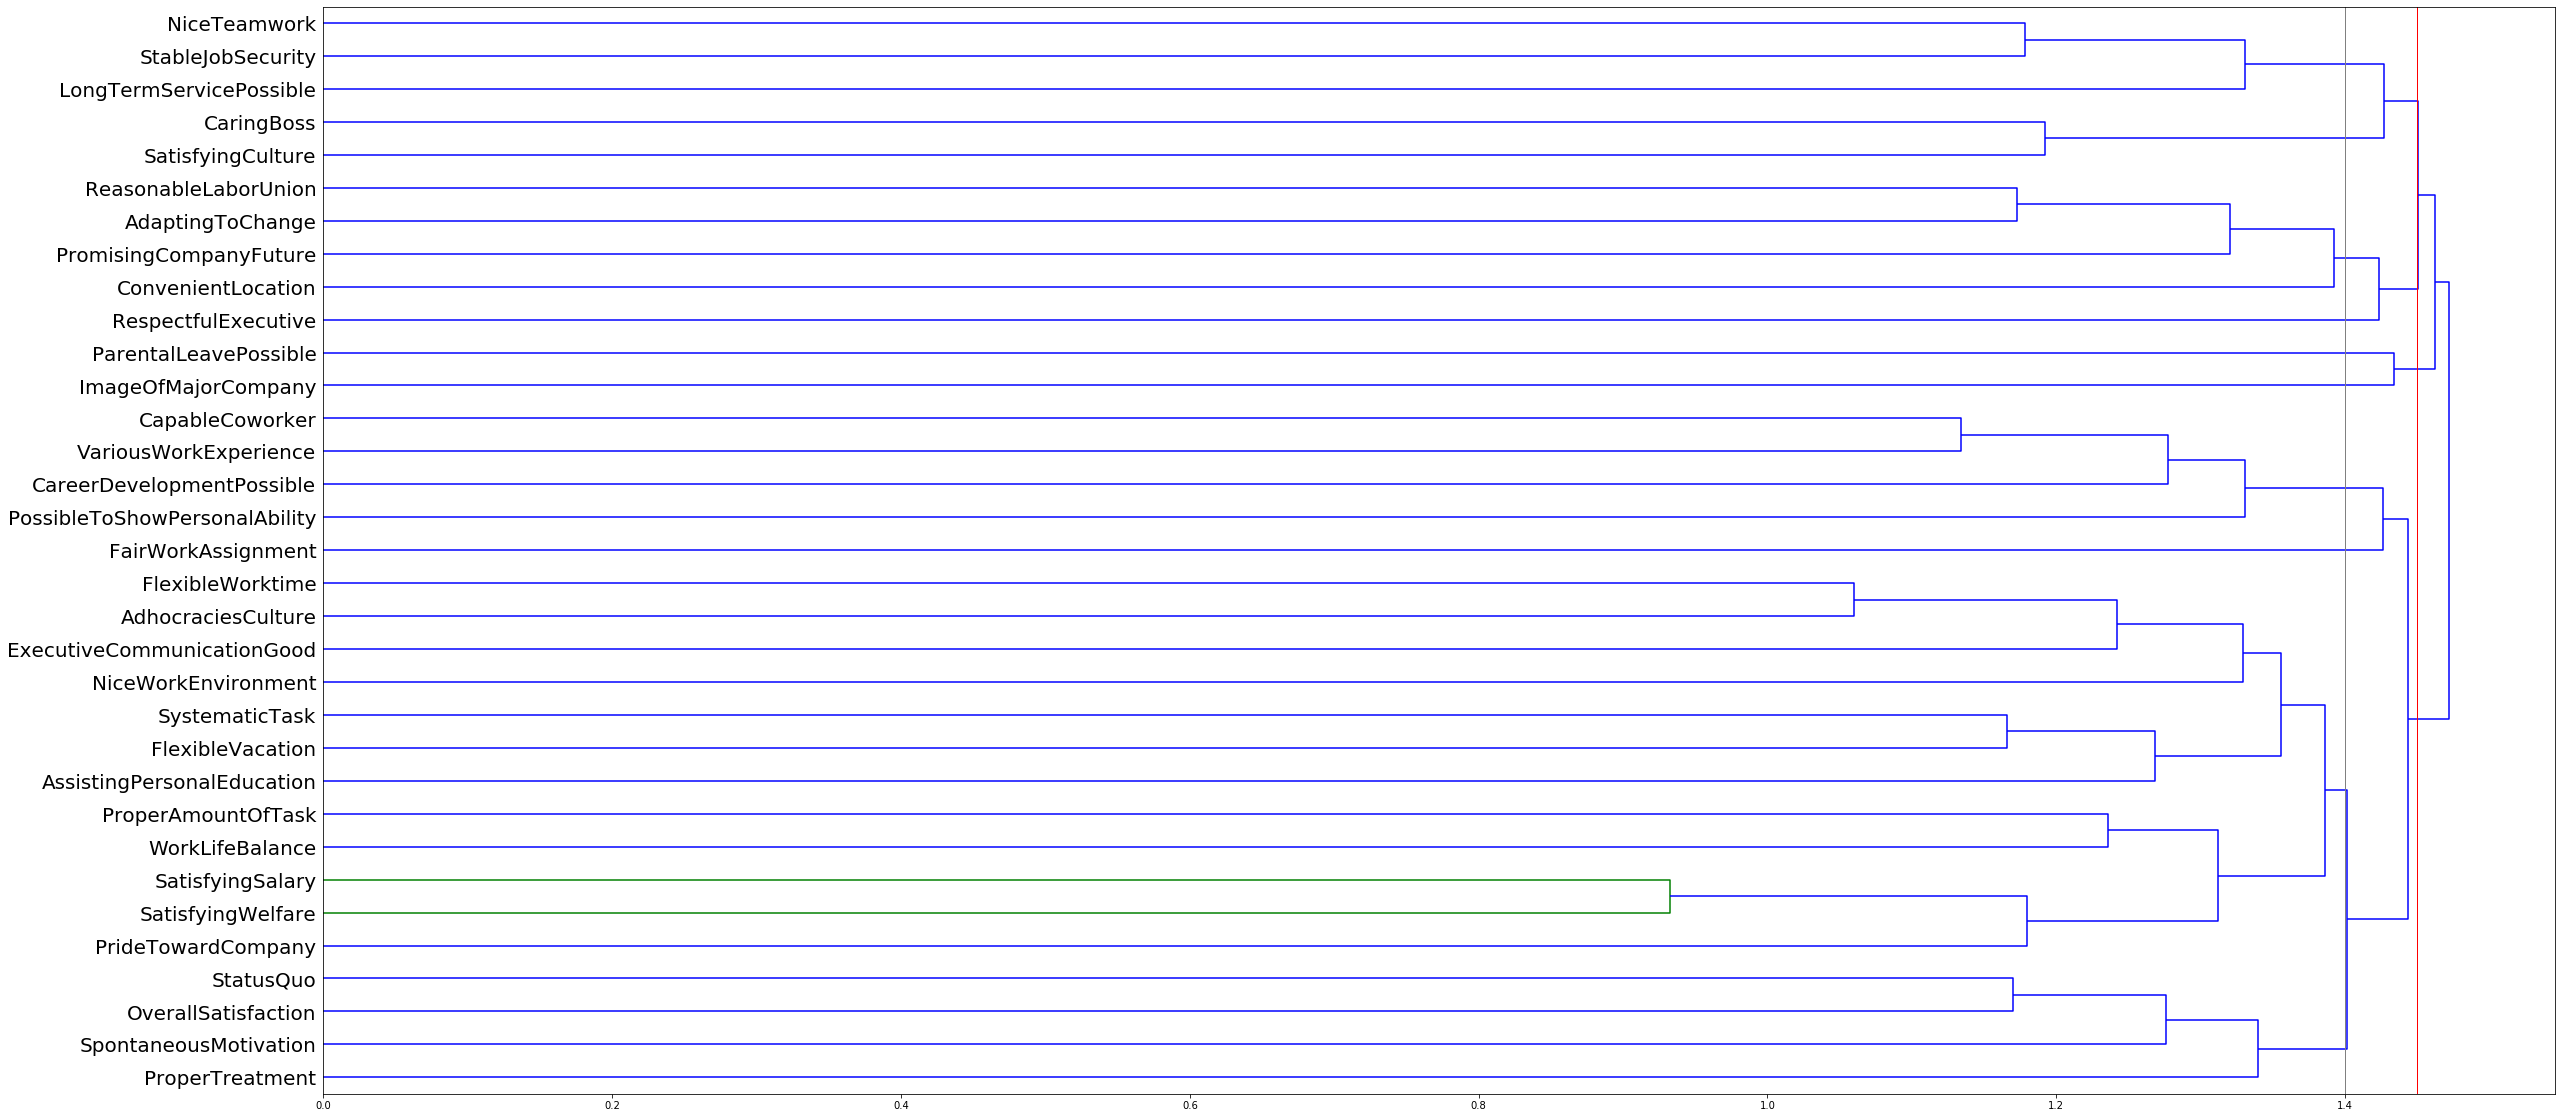

In [18]:

plt.figure(figsize=(40,20))
sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                         labels = co_occurence_matrix_df.columns, 
                                         orientation = 'right',
                                         leaf_font_size=20,
                                         show_contracted = True)
plt.axvline(x= 1.45, c='red', lw = 1)
plt.axvline(x= 1.4, c='grey', lw = 1);
##plt.savefig('highadvantage.png');


## Interpreting the Dendrogram

(1) Clustering Standard based on 1.45 and 1.4 Distance. 

(2) Total Cluster could be divided into four clusters based on 1.5 distance. 


**Cluster1** - NiceTeamwork, StableJobSecurity, LongTermServicePossible, CaringBoss, SatisfyingCulture

**Cluster2** - ReasonableLaborUnion, AdaptingToChange, PromisingCompanyFuture, ConvenientLocation, RespectfulExecutive

**Cluster3** - ParentalLeavePossible, ImageOfMajorCompany

**Cluster4** - CapableCoworker, VariousWorkExperience, CareerDevelopmentPossible, PossibleToShowPersonalAbility, FairWorkAssignment, FlexibleWorkTime, AdhocraciesCulture, ExecutiveCommunicationGood, NiceWorkEnvironment, SystematicTask, FlexibleVacation, AssistingPersonalEducation, ProperAmountOfTask, WorkLifeBalance, SatisfyingSalary, SatisfyingWelfare, PrideTowardCompany, StatusQuo, OverallSatisfaction, SpontaneousMotivation, ProperTreatment
    
    Cluster 4 - 1 CapableCoworker, VariousWorkExperience, CareerDevelopmentPossible, PossibleToShowPersonalAbility
    Cluster 4 - 2 FairWorkAssignment
    Cluster 4 - 3 FlexibleWorkTime, AdhocraciesCulture, ExecutiveCommunicationGood, NiceWorkEnvironment, SystematicTask, FlexibleVacation, AssistingPersonalEducation, ProperAmountOfTask, WorkLifeBalance, SatisfyingSalary, SatisfyingWelfare, PrideTowardCompany
    Cluster 4 - 4 StatusQuo, OverallSatisfaction, SpontaneousMotivation, ProperTreatment





### (3) Calculating Average Distance Portion of Each Cluster

In [20]:
co_occurence_matrix_df.head()

,AssistingPersonalEducation,PossibleToShowPersonalAbility,CareerDevelopmentPossible,RespectfulExecutive,StableJobSecurity,FairWorkAssignment,PrideTowardCompany,VariousWorkExperience,CapableCoworker,ImageOfMajorCompany,...,FlexibleWorktime,LongTermServicePossible,ProperAmountOfTask,OverallSatisfaction,NiceWorkEnvironment,NiceTeamwork,SystematicTask,ReasonableLaborUnion,ProperTreatment,StatusQuo
AssistingPersonalEducation,1.000000,0.000,0.153093,0.0,0.0,0.0,0.000000,0.0000,0.045083,0.000000,...,0.123718,0.000000,0.000000,0.000000,0.046225,0.000000,0.077152,0.0,0.064550,0.000000
PossibleToShowPersonalAbility,0.000000,1.000,0.125000,0.0,0.0,0.0,0.000000,0.0000,0.220863,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
CareerDevelopmentPossible,0.153093,0.125,1.000000,0.0,0.0,0.0,0.188707,0.0533,0.248471,0.079057,...,0.025254,0.000000,0.079057,0.068041,0.113228,0.000000,0.047246,0.0,0.039528,0.098058
RespectfulExecutive,0.000000,0.000,0.000000,1.0,0.0,0.0,0.000000,0.0000,0.090167,0.000000,...,0.082479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160128
StableJobSecurity,0.000000,0.000,0.000000,0.0,1.0,0.0,0.048224,0.0000,0.000000,0.000000,...,0.000000,0.182574,0.070711,0.000000,0.000000,0.223607,0.000000,0.0,0.000000,0.000000


In [21]:
##code for calculating total distance from diagonal matrix
column_sum = [co_occurence_matrix_df.iloc[i].sum() for i in range(co_occurence_matrix_df.shape[0])]
total_distance = (sum(column_sum) - co_occurence_matrix_df.shape[0])/2


##Code Plan for Calculating Ratio
## 1. Subsetting cosine matrix for each cluster. 
## 2. Apply same code as total distance code


##For Cluster 1

cluster1_list = ['NiceTeamwork', 'StableJobSecurity', 'LongTermServicePossible', 'CaringBoss, SatisfyingCulture']

cluster2_list = ['ReasonableLaborUnion', 'AdaptingToChange', 'PromisingCompanyFuture', 'ConvenientLocation', 'RespectfulExecutive']
cluster3_list = ['ParentalLeavePossible', 'ImageOfMajorCompany']


cluster4_list = ['CapableCoworker', 'VariousWorkExperience', 'CareerDevelopmentPossible', 'PossibleToShowPersonalAbility', 
                 'FairWorkAssignment', 'FlexibleWorkTime', 'AdhocraciesCulture', 'ExecutiveCommunicationGood', 
                 'NiceWorkEnvironment', 'SystematicTask', 'FlexibleVacation', 'AssistingPersonalEducation', 'ProperAmountOfTask', 
                 'WorkLifeBalance', 'SatisfyingSalary', 'SatisfyingWelfare', 'PrideTowardCompany', 'StatusQuo', 'OverallSatisfaction', 'SpontaneousMotivation', 'ProperTreatment']

c4_1_list = ['CapableCoworker', 'VariousWorkExperience', 'CareerDevelopmentPossible', 'PossibleToShowPersonalAbility']
c4_2_list = ['FairWorkAssignment']
c4_3_list = ['FlexibleWorkTime', 'AdhocraciesCulture', 'ExecutiveCommunicationGood', 
            'NiceWorkEnvironment', 'SystematicTask', 'FlexibleVacation', 'AssistingPersonalEducation', 'ProperAmountOfTask', 
            'WorkLifeBalance', 'SatisfyingSalary', 'SatisfyingWelfare', 'PrideTowardCompany']
c4_4_list = ['StatusQuo', 'OverallSatisfaction', 'SpontaneousMotivation', 'ProperTreatment']



c1 = co_occurence_matrix_df.copy()
c2 = co_occurence_matrix_df.copy()
c3 = co_occurence_matrix_df.copy()
c4 = co_occurence_matrix_df.copy()

In [22]:
##subset matrix for cluster 1
for i in c1.columns:
    if i not in cluster1_list:
        c1.drop(i, axis = 1, inplace = True)
        c1.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 2
for i in c2.columns:
    if i not in cluster2_list:
        c2.drop(i, axis = 1, inplace = True)
        c2.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 3
for i in c3.columns:
    if i not in cluster3_list:
        c3.drop(i, axis = 1, inplace = True)
        c3.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 4
for i in c4.columns:
    if i not in cluster4_list:
        c4.drop(i, axis = 1, inplace = True)
        c4.drop(i, axis = 0, inplace = True)

In [23]:
co_occurence_matrix_df.head()

,AssistingPersonalEducation,PossibleToShowPersonalAbility,CareerDevelopmentPossible,RespectfulExecutive,StableJobSecurity,FairWorkAssignment,PrideTowardCompany,VariousWorkExperience,CapableCoworker,ImageOfMajorCompany,...,FlexibleWorktime,LongTermServicePossible,ProperAmountOfTask,OverallSatisfaction,NiceWorkEnvironment,NiceTeamwork,SystematicTask,ReasonableLaborUnion,ProperTreatment,StatusQuo
AssistingPersonalEducation,1.000000,0.000,0.153093,0.0,0.0,0.0,0.000000,0.0000,0.045083,0.000000,...,0.123718,0.000000,0.000000,0.000000,0.046225,0.000000,0.077152,0.0,0.064550,0.000000
PossibleToShowPersonalAbility,0.000000,1.000,0.125000,0.0,0.0,0.0,0.000000,0.0000,0.220863,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
CareerDevelopmentPossible,0.153093,0.125,1.000000,0.0,0.0,0.0,0.188707,0.0533,0.248471,0.079057,...,0.025254,0.000000,0.079057,0.068041,0.113228,0.000000,0.047246,0.0,0.039528,0.098058
RespectfulExecutive,0.000000,0.000,0.000000,1.0,0.0,0.0,0.000000,0.0000,0.090167,0.000000,...,0.082479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160128
StableJobSecurity,0.000000,0.000,0.000000,0.0,1.0,0.0,0.048224,0.0000,0.000000,0.000000,...,0.000000,0.182574,0.070711,0.000000,0.000000,0.223607,0.000000,0.0,0.000000,0.000000


In [24]:
## Goodness of Fit for Clustering Model

column_sum = [co_occurence_matrix_df.iloc[i].sum() for i in range(co_occurence_matrix_df.shape[0])]
total_distance = (sum(column_sum) - co_occurence_matrix_df.shape[0])/2

c1_distance_portion = ((sum([c1.iloc[i].sum() for i in range(c1.shape[0])]) - c1.shape[0])/2)
c2_distance_portion = ((sum([c2.iloc[i].sum() for i in range(c2.shape[0])]) - c2.shape[0])/2)
c3_distance_portion = ((sum([c3.iloc[i].sum() for i in range(c3.shape[0])]) - c3.shape[0])/2)
c4_distance_portion = ((sum([c4.iloc[i].sum() for i in range(c4.shape[0])]) - c4.shape[0])/2)


portion_list = [c1_distance_portion, c2_distance_portion, c3_distance_portion, c4_distance_portion]


goodness_of_fit = sum(portion_list)/total_distance*100
print(goodness_of_fit)


62.671235774412345


In [25]:
##Clustering 1's Proportion 

total_portion = [c1_distance_portion,c2_distance_portion,c3_distance_portion,c4_distance_portion]
c1_portion = c1_distance_portion / sum(total_portion)
c2_portion = c2_distance_portion / sum(total_portion)
c3_portion = c3_distance_portion / sum(total_portion)
c4_portion = c4_distance_portion / sum(total_portion)

df = [c1_portion, c2_portion,c3_portion, c4_portion]
index_df = ['c1_portion', 'c2_portion', 'c3_portion', 'c4_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c1_portion,0.025372
c2_portion,0.042593
c3_portion,0.000000
c4_portion,0.932035


## Detail Cluster Analysis

In [26]:
c4_1 = co_occurence_matrix_df.copy()
c4_2 = co_occurence_matrix_df.copy()
c4_3 = co_occurence_matrix_df.copy()
c4_4 = co_occurence_matrix_df.copy()

##subset matrix for cluster 1
for i in c4_1.columns:
    if i not in c4_1_list:
        c4_1.drop(i, axis = 1, inplace = True)
        c4_1.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 2
for i in c4_2.columns:
    if i not in c4_2_list:
        c4_2.drop(i, axis = 1, inplace = True)
        c4_2.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 3
for i in c4_3.columns:
    if i not in c4_3_list:
        c4_3.drop(i, axis = 1, inplace = True)
        c4_3.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 4
for i in c4_4.columns:
    if i not in c4_4_list:
        c4_4.drop(i, axis = 1, inplace = True)
        c4_4.drop(i, axis = 0, inplace = True)

In [27]:
c4_1_distance = ((sum([c4_1.iloc[i].sum() for i in range(c4_1.shape[0])]) - c4_1.shape[0])/2)
c4_2_distance = ((sum([c4_2.iloc[i].sum() for i in range(c4_2.shape[0])]) - c4_2.shape[0])/2)
c4_3_distance = ((sum([c4_3.iloc[i].sum() for i in range(c4_3.shape[0])]) - c4_3.shape[0])/2)
c4_4_distance = ((sum([c4_4.iloc[i].sum() for i in range(c4_4.shape[0])]) - c4_4.shape[0])/2)

c4_distance = ((sum([c4.iloc[i].sum() for i in range(c4.shape[0])]) - c4.shape[0])/2)

c4_1_portion = c4_1_distance / sum(total_portion)
c4_2_portion = c4_2_distance / sum(total_portion)
c4_3_portion = c4_3_distance / sum(total_portion)
c4_4_portion = c4_4_distance / sum(total_portion)

df = [c4_1_portion, c4_2_portion,c4_3_portion, c4_4_portion]
index_df = ['c4_1_portion', 'c4_2_portion', 'c4_3_portion', 'c4_4_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c4_1_portion,0.058103
c4_2_portion,0.000000
c4_3_portion,0.391092
c4_4_portion,0.047975


## Report


Among all clusters, the highest average distance of a cluster was cluster 4 - 3 whose elements are as follows. 


**Cluster 4 - 3** FlexibleWorkTime, AdhocraciesCulture, ExecutiveCommunicationGood, NiceWorkEnvironment, SystematicTask, FlexibleVacation, AssistingPersonalEducation, ProperAmountOfTask, WorkLifeBalance, SatisfyingSalary, SatisfyingWelfare, PrideTowardCompany

On the basis of this analysis result, it is possible to conclude that flexible working environment, good communication and other components had the most powerful impact.


## 3 -(2) Hierarchical Clustering Analysis for High Drawback Total

In [42]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(high_keyword_df.drawback_total)
x_transpose = x.transpose()
cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
##Co-Occurence Matrix based on Cosine Distance
labels = vectorizer.get_feature_names()
co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
##Eliminating Needless Columns
for i in co_occurence_matrix_df.columns:
    if i not in negative:
        co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
        co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
    else:
        pass
    
##Translating Column Names into English(Korean is not allowed in dendrogram package)
eng_column = translation(co_occurence_matrix_df.columns)
co_occurence_matrix_df.columns = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility','CareerDevelopmentImpossible', 'OnlyResultMatters',
       'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking',
       'TransferOfContractWorker', 'UnfairContractWorker',
       'CustomerCommunicationProblem', 'UnstableJobSecurity', 'BigBrotherBoss',
       'OverwhelmingAmountOfTask', 'ShiftWorkSystem', 'LaborExecutiveConflict',
       'MonotonousWork', 'NeedForCultureRenovation', 'ReluctantToChange',
       'NeedToChange', 'CulturalDifferenceByDepartment',
       'TaskAmountDifferenceByDepartment', 'NegativeMarketSituation',
       'NeedForCleaningCorruption', 'UnfairWorkAssignment', 'UnsatisfyingWelfare',
       'UnsatisfyingSalary', 'UnstableCompanyFuture', 'UnreasonableLaborUnion',
       'UnsystematicTask', 'UnreasonablePerformanceEvaluation', 'InproperTreatment',
       'FrequentStrike', 'Offitics', 'ComparativeDeprivation',
       'NeedForGenerationChange', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'BadProductQuality',
       'NotWorkingEmployees', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation', 'UnflexibleWorktime',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadTeamwork', 'FierceCompetition', 'NeedForAdditionalInvestment']

co_occurence_matrix_df.index = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility','CareerDevelopmentImpossible', 'OnlyResultMatters',
       'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking',
       'TransferOfContractWorker', 'UnfairContractWorker',
       'CustomerCommunicationProblem', 'UnstableJobSecurity', 'BigBrotherBoss',
       'OverwhelmingAmountOfTask', 'ShiftWorkSystem', 'LaborExecutiveConflict',
       'MonotonousWork', 'NeedForCultureRenovation', 'ReluctantToChange',
       'NeedToChange', 'CulturalDifferenceByDepartment',
       'TaskAmountDifferenceByDepartment', 'NegativeMarketSituation',
       'NeedForCleaningCorruption', 'UnfairWorkAssignment', 'UnsatisfyingWelfare',
       'UnsatisfyingSalary', 'UnstableCompanyFuture', 'UnreasonableLaborUnion',
       'UnsystematicTask', 'UnreasonablePerformanceEvaluation', 'InproperTreatment',
       'FrequentStrike', 'Offitics', 'ComparativeDeprivation',
       'NeedForGenerationChange', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'BadProductQuality',
       'NotWorkingEmployees', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation', 'UnflexibleWorktime',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadTeamwork', 'FierceCompetition', 'NeedForAdditionalInvestment']
    
   

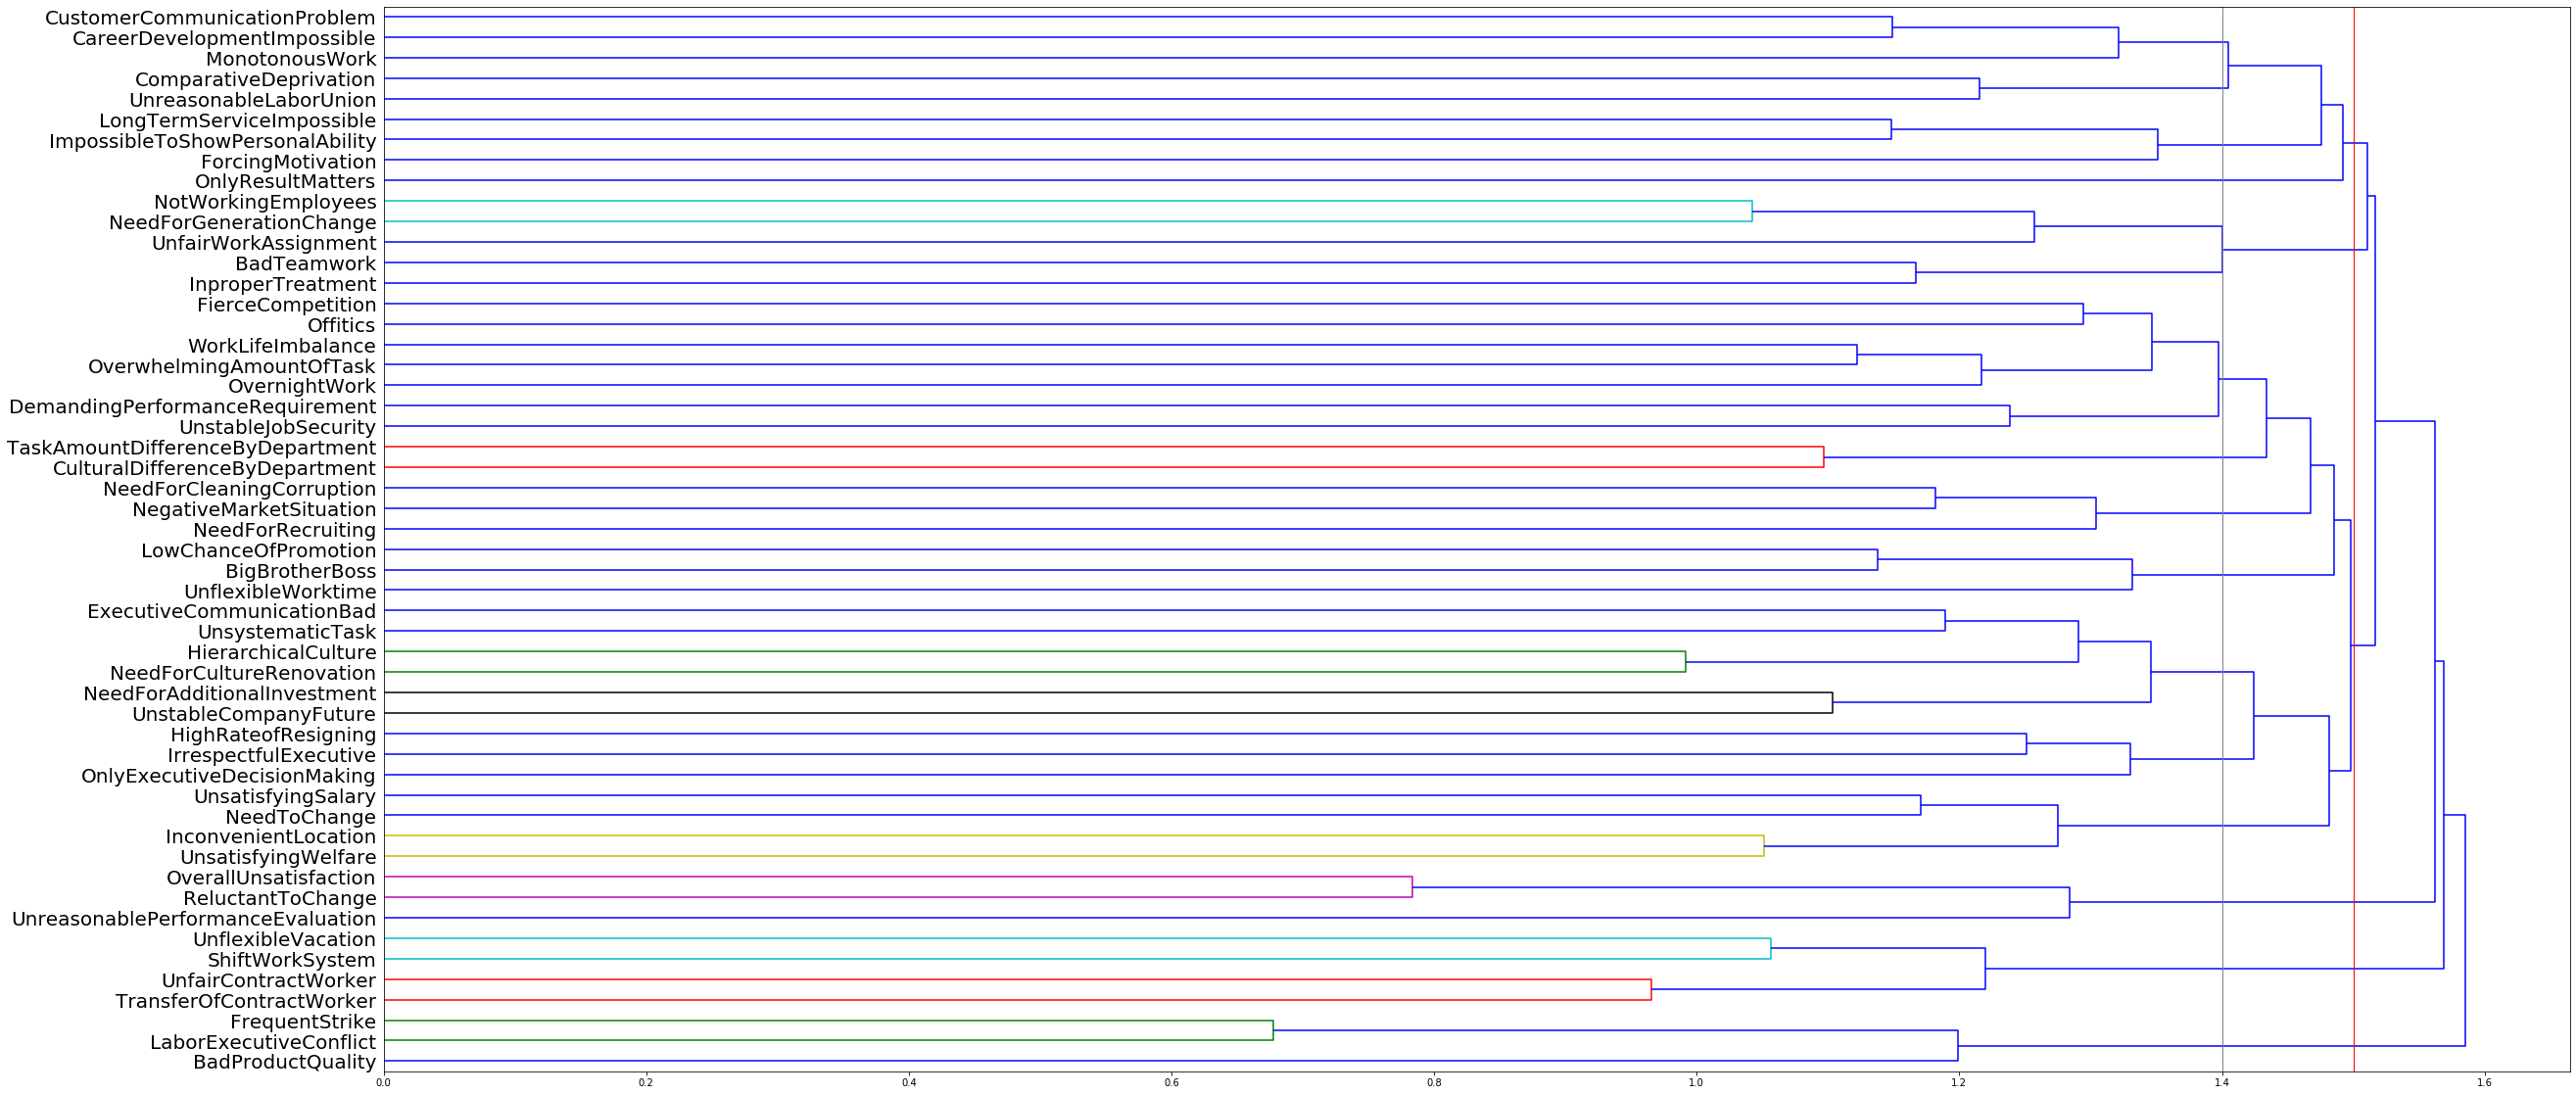

In [43]:
plt.figure(figsize=(40,20))
sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                             labels = co_occurence_matrix_df.columns, 
                                             orientation = 'right',
                                             leaf_font_size=20,
                                             show_contracted = True)
plt.axvline(x= 1.5, c='red', lw = 1)
plt.axvline(x= 1.4, c='grey', lw = 1);
##plt.savefig('highdrawback.png')

## Interpreting the Dendrogram

(1) Clustering Standard based on 1.5 and 1.4 Distance. 
(2) Total Cluster could be divided into seven clusters based on 1.5 distance. 

 **Cluster 1** - CustomerCommunicationProblem, CareerDevelopmentImpossible, MonotonousWork, ComparativeDeprivation, UnreasonableLaborUnion, LongTermServiceImpossible, ImpossibleToShowPersonalAbility, ForcingMotivation,OnlyResultMatters
 
 **Cluster 2** - NotWorkingEmployees, NeedForGenerationChange, UnfairWorkAssignment, BadTeamwork, InproperTreatment
 
 **Cluster 3** - FierceCompetition, Offitics, WorkLifeImbalance, OverwhelmingAmountOfTask, Overnightwork, DemandingPerformanceRequirement, UnstableJobSecurity, TaskAmountDifferenceByDepartment, CulturalDifferenceByDepartment, NeedForCleaningCorruption, NegativeMarketSituation, NeedForRecruiting, LowChanceOfPromotion, BigBrotherBoss, UnflexibleWorktime
 
     Cluster 3 - 1 FierceCompetition, Offitics, WorkLifeImbalance, OverwhelmingAmountOfTask, Overnightwork, DemandingPerformanceRequirement, UnstableJobSecurity
     Cluster 3 - 2 TaskAmountDifferenceByDepartment, CulturalDifferenceByDepartment
     Cluster 3 - 3 NeedForCleaningCorruption, NegativeMarketSituation, NeedForRecruiting
     Cluster 3 - 4 LowChanceOfPromotion, BigBrotherBoss, UnflexibleWorktime
 
 
 **Cluster 4** - ExecutiveCommunicationBad, UnsystematicTask, HierarchicalCulture, NeedForCultureRenovation, NeedForAdditionalInvestment, UnstableCompanyFuture, HighRateOfResigning, IrrespecfulExecutive, OnlyExecutiveDecisionMaking, UnsatisfyingSalary, NeedToChange, InconvenientLocation, UnsatisfyingWelfare
 
     Cluster 4 - 1 ExecutiveCommunicationBad, UnsystematicTask, HierarchicalCulture, NeedForCultureRenovation, NeedForAdditionalInvestment, UnstableCompanyFuture
     Cluster 4 - 2 HighRateOfResigning, IrrespecfulExecutive, OnlyExecutiveDecisionMaking
     Cluster 4 - 3 UnsatisfyingSalary, NeedToChange, InconvenientLocation, UnsatisfyingWelfare
 
 
 **Cluster 5** - OverallUnsatisfaction, ReluctantToChange, UnreasonablePerformanceEvaluation
 
 **Cluster 6** - UnflexibleVacation, ShiftWorkSystem, UnfairContractWorker, TransferOfContractWorker
 
 **Cluster 7** - FrequentStrike, LaborExecutiveConflict, BadProductQuality
 
 ### (2) -1 Calculating Average Distance Portion of Each Cluster


In [44]:
co_occurence_matrix_df.head()

,ForcingMotivation,ImpossibleToShowPersonalAbility,CareerDevelopmentImpossible,OnlyResultMatters,IrrespectfulExecutive,OnlyExecutiveDecisionMaking,TransferOfContractWorker,UnfairContractWorker,CustomerCommunicationProblem,UnstableJobSecurity,...,ExecutiveCommunicationBad,InconvenientLocation,UnflexibleVacation,UnflexibleWorktime,LongTermServiceImpossible,OvernightWork,OverallUnsatisfaction,BadTeamwork,FierceCompetition,NeedForAdditionalInvestment
ForcingMotivation,1.000000,0.176777,0.138675,0.0,0.085749,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.133199,0.000000,0.0,0.0,0.00,0.000000,0.0,0.204124,0.000000,0.063500
ImpossibleToShowPersonalAbility,0.176777,1.000000,0.098058,0.0,0.060634,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.196934,0.000000,0.0,0.0,0.25,0.000000,0.0,0.144338,0.000000,0.089803
CareerDevelopmentImpossible,0.138675,0.098058,1.000000,0.0,0.142695,0.071611,0.080064,0.043315,0.27735,0.098058,...,0.174638,0.113228,0.0,0.0,0.00,0.062017,0.0,0.000000,0.000000,0.105670
OnlyResultMatters,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.024218,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.127000
IrrespectfulExecutive,0.085749,0.060634,0.142695,0.0,1.000000,0.088561,0.000000,0.000000,0.00000,0.121268,...,0.299041,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.045835,0.152462


In [53]:
##code for calculating total distance from diagonal matrix
column_sum = [co_occurence_matrix_df.iloc[i].sum() for i in range(co_occurence_matrix_df.shape[0])]
total_distance = (sum(column_sum) - co_occurence_matrix_df.shape[0])/2


##Code Plan for Calculating Ratio
## 1. Subsetting cosine matrix for each cluster. 
## 2. Apply same code as total distance code


##For Cluster 1

cluster1_list = ['CustomerCommunicationProblem', 'CareerDevelopmentImpossible', 'MonotonousWork', 'ComparativeDeprivation', 'UnreasonableLaborUnion', 
                 'LongTermServiceImpossible', 'ImpossibleToShowPersonalAbility', 'ForcingMotivation', 'OnlyResultMatters']
cluster2_list = ['NotWorkingEmployees', 'NeedForGenerationChange', 'UnfairWorkAssignment', 'BadTeamwork', 'InproperTreatment']
cluster3_list = ['FierceCompetition', 'Offitics', 'WorkLifeImbalance', 'OverwhelmingAmountOfTask', 'OvernightWork', 'DemandingPerformanceRequirement', 
                 'UnstableJobSecurity', 'TaskAmountDifferenceByDepartment', 'CulturalDifferenceByDepartment', 'NeedForCleaningCorruption', 
                 'NegativeMarketSituation', 'NeedForRecruiting', 'LowChanceOfPromotion', 'BigBrotherBoss', 'UnflexibleWorktime']

c3_1_list = ['FierceCompetition', 'Offitics', 'WorkLifeImbalance', 'OverwhelmingAmountOfTask', 'OvernightWork', 'DemandingPerformanceRequirement', 'UnstableJobSecurity']
c3_2_list = ['TaskAmountDifferenceByDepartment', 'CulturalDifferenceByDepartment']
c3_3_list = ['NeedForCleaningCorruption', 'NegativeMarketSituation', 'NeedForRecruiting']
c3_4_list = ['LowChanceOfPromotion', 'BigBrotherBoss', 'UnflexibleWorktime']


cluster4_list = ['ExecutiveCommunicationBad', 'UnsystematicTask', 'HierarchicalCulture', 'NeedForCultureRenovation', 'NeedForAdditionalInvestment', 'UnstableCompanyFuture', 
                 'HighRateofResigning', 'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking', 'UnsatisfyingSalary', 'NeedToChange', 'InconvenientLocation', 'UnsatisfyingWelfare']

c4_1_list = ['ExecutiveCommunicationBad', 'UnsystematicTask', 'HierarchicalCulture', 'NeedForCultureRenovation', 'NeedForAdditionalInvestment', 'UnstableCompanyFuture']
c4_2_list = ['HighRateofResigning', 'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking']
c4_3_list = ['UnsatisfyingSalary', 'NeedToChange', 'InconvenientLocation', 'UnsatisfyingWelfare']


cluster5_list = ['OverallUnsatisfaction', 'ReluctantToChange', 'UnreasonablePerformanceEvaluation']

cluster6_list = ['UnflexibleVacation', 'ShiftWorkSystem', 'UnfairContractWorker', 'TransferOfContractWorker']
cluster7_list = ['FrequentStrike', 'LaborExecutiveConflict', 'BadProductQuality']

c1 = co_occurence_matrix_df.copy()
c2 = co_occurence_matrix_df.copy()
c3 = co_occurence_matrix_df.copy()
c4 = co_occurence_matrix_df.copy()
c5 = co_occurence_matrix_df.copy()
c6 = co_occurence_matrix_df.copy()
c7 = co_occurence_matrix_df.copy()


In [54]:
##subset matrix for cluster 1
for i in c1.columns:
    if i not in cluster1_list:
        c1.drop(i, axis = 1, inplace = True)
        c1.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 2
for i in c2.columns:
    if i not in cluster2_list:
        c2.drop(i, axis = 1, inplace = True)
        c2.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 3
for i in c3.columns:
    if i not in cluster3_list:
        c3.drop(i, axis = 1, inplace = True)
        c3.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 4
for i in c4.columns:
    if i not in cluster4_list:
        c4.drop(i, axis = 1, inplace = True)
        c4.drop(i, axis = 0, inplace = True)
        
        
##subset matrix for cluster 5
for i in c5.columns:
    if i not in cluster5_list:
        c5.drop(i, axis = 1, inplace = True)
        c5.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 6
for i in c6.columns:
    if i not in cluster6_list:
        c6.drop(i, axis = 1, inplace = True)
        c6.drop(i, axis = 0, inplace = True)

##subset matrix for cluster 7
for i in c7.columns:
    if i not in cluster7_list:
        c7.drop(i, axis = 1, inplace = True)
        c7.drop(i, axis = 0, inplace = True)

In [55]:
## Goodness of Fit for Clustering Model

c1_distance_portion = ((sum([c1.iloc[i].sum() for i in range(c1.shape[0])]) - c1.shape[0])/2)/total_distance*100
c2_distance_portion = ((sum([c2.iloc[i].sum() for i in range(c2.shape[0])]) - c2.shape[0])/2)/total_distance*100
c3_distance_portion = ((sum([c3.iloc[i].sum() for i in range(c3.shape[0])]) - c3.shape[0])/2)/total_distance*100
c4_distance_portion = ((sum([c4.iloc[i].sum() for i in range(c4.shape[0])]) - c4.shape[0])/2)/total_distance*100
c5_distance_portion = ((sum([c5.iloc[i].sum() for i in range(c5.shape[0])]) - c5.shape[0])/2)/total_distance*100
c6_distance_portion = ((sum([c6.iloc[i].sum() for i in range(c6.shape[0])]) - c6.shape[0])/2)/total_distance*100
c7_distance_portion = ((sum([c7.iloc[i].sum() for i in range(c7.shape[0])]) - c7.shape[0])/2)/total_distance*100

portion_list = [c1_distance_portion, c2_distance_portion, c3_distance_portion, c4_distance_portion, c5_distance_portion, c6_distance_portion, c7_distance_portion]


goodness_of_fit = sum(portion_list)/total_distance*100
print(goodness_of_fit)


72.38479417514151


In [66]:
##Clustering 1's Proportion 

total_portion = [c1_distance_portion,c2_distance_portion,c3_distance_portion,c4_distance_portion,c5_distance_portion,c6_distance_portion,c7_distance_portion]
c1_portion = c1_distance_portion / sum(total_portion)
c2_portion = c2_distance_portion / sum(total_portion)
c3_portion = c3_distance_portion / sum(total_portion)
c4_portion = c4_distance_portion / sum(total_portion)
c5_portion = c5_distance_portion / sum(total_portion)
c6_portion = c6_distance_portion / sum(total_portion)
c7_portion = c7_distance_portion / sum(total_portion)

df = [c1_portion, c2_portion,c3_portion, c4_portion,c5_portion,c6_portion,c7_portion]
index_df = ['c1_portion', 'c2_portion', 'c3_portion', 'c4_portion', 'c5_portion', 'c6_portion', 'c7_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c1_portion,0.087119
c2_portion,0.068464
c3_portion,0.254194
c4_portion,0.447888
c5_portion,0.036345
c6_portion,0.064050
c7_portion,0.041940


### Report

By ordering clusters based on their explanation power, the sequence are as follows.

c4 > c3 > c1 > c2 > c6 > c7 > c5

However, c4 and c3 contains too many subsets, it does not provide useful insight. So these two clusters is going to be interpreted more deeply on following section.

Only considering c1, c2, c6, and c7, the result could be suggested as following.



**Cluster 1** - CustomerCommunicationProblem, CareerDevelopmentImpossible, MonotonousWork, ComparativeDeprivation, UnreasonableLaborUnion, LongTermServiceImpossible, ImpossibleToShowPersonalAbility, ForcingMotivation,OnlyResultMatters -> **"Individual's Career Related Issues / 개인 커리어 발전 관련 이슈"**
 
**Cluster 2** - NotWorkingEmployees, NeedForGenerationChange, UnfairWorkAssignment, BadTeamwork, InproperTreatment -> **"Generation Conflict & Treatment Issue / 세대갈등 및 대우 문제"**
 
**Cluster 6** - UnflexibleVacation, ShiftWorkSystem, UnfairContractWorker, TransferOfContractWorker -> **"Working Condition Environment / 근무 제도 이슈"**
 
**Cluster 7** - FrequentStrike, LaborExecutiveConflict, BadProductQuality -> **"Labor Union Issue / 노사 관련 이슈"**

**Cluster 5** - OverallUnsatisfaction, ReluctantToChange, UnreasonablePerformanceEvaluation -> **"Company Environment against Change / 변화를 수용 못하는 분위기"**
 




### For More Detail

Cluster3 and Cluster4 are too high since there are more number of subsets than other clusters

It is going to be natural to divide into more detail subsets

In [69]:
c3_1 = co_occurence_matrix_df.copy()
c3_2 = co_occurence_matrix_df.copy()
c3_3 = co_occurence_matrix_df.copy()
c3_4 = co_occurence_matrix_df.copy()

c4_1 = co_occurence_matrix_df.copy()
c4_2 = co_occurence_matrix_df.copy()
c4_3 = co_occurence_matrix_df.copy()



for i in c3_1.columns:
    if i not in c3_1_list:
        c3_1.drop(i, axis = 1, inplace = True)
        c3_1.drop(i, axis = 0, inplace = True)

for i in c3_2.columns:
    if i not in c3_2_list:
        c3_2.drop(i, axis = 1, inplace = True)
        c3_2.drop(i, axis = 0, inplace = True)

for i in c3_3.columns:
    if i not in c3_3_list:
        c3_3.drop(i, axis = 1, inplace = True)
        c3_3.drop(i, axis = 0, inplace = True)
        
for i in c3_4.columns:
    if i not in c3_4_list:
        c3_4.drop(i, axis = 1, inplace = True)
        c3_4.drop(i, axis = 0, inplace = True)


for i in c4_1.columns:
    if i not in c4_1_list:
        c4_1.drop(i, axis = 1, inplace = True)
        c4_1.drop(i, axis = 0, inplace = True)

for i in c4_2.columns:
    if i not in c4_2_list:
        c4_2.drop(i, axis = 1, inplace = True)
        c4_2.drop(i, axis = 0, inplace = True)

for i in c4_3.columns:
    if i not in c4_3_list:
        c4_3.drop(i, axis = 1, inplace = True)
        c4_3.drop(i, axis = 0, inplace = True)


        
c3_1_distance = (sum([c3_1.iloc[i].sum() for i in range(c3_1.shape[0])]) - c3_1.shape[0])/2
c3_2_distance = (sum([c3_2.iloc[i].sum() for i in range(c3_2.shape[0])]) - c3_2.shape[0])/2
c3_3_distance = (sum([c3_3.iloc[i].sum() for i in range(c3_3.shape[0])]) - c3_3.shape[0])/2
c3_4_distance = (sum([c3_4.iloc[i].sum() for i in range(c3_4.shape[0])]) - c3_4.shape[0])/2

c4_1_distance = (sum([c4_1.iloc[i].sum() for i in range(c4_1.shape[0])]) - c4_1.shape[0])/2
c4_2_distance = (sum([c4_2.iloc[i].sum() for i in range(c4_2.shape[0])]) - c4_2.shape[0])/2
c4_3_distance = (sum([c4_3.iloc[i].sum() for i in range(c4_3.shape[0])]) - c4_3.shape[0])/2

In [70]:
c3_1_portion = c3_1_distance / sum(total_portion)
c3_2_portion = c3_2_distance / sum(total_portion)
c3_3_portion = c3_3_distance / sum(total_portion)
c3_4_portion = c3_4_distance / sum(total_portion)

c4_1_portion = c4_1_distance / sum(total_portion)
c4_2_portion = c4_2_distance / sum(total_portion)
c4_3_portion = c4_3_distance / sum(total_portion)



df = [c3_1_portion, c3_2_portion, c3_3_portion, c3_4_portion,
     c4_1_portion, c4_2_portion, c4_3_portion]

index_df = ['c3_1_portion', 'c3_2_portion', 'c3_3_portion', 'c3_4_portion',
     'c4_1_portion', 'c4_2_portion', 'c4_3_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c3_1_portion,0.057993
c3_2_portion,0.006687
c3_3_portion,0.010995
c3_4_portion,0.011314
c4_1_portion,0.089962
c4_2_portion,0.009363
c4_3_portion,0.031915


### Report

In terms of c3, the explanation power is c3_1 > c3_4 > c3_3 > c3_2.

**Cluster 3 - 1** FierceCompetition, Offitics, WorkLifeImbalance, OverwhelmingAmountOfTask, Overnightwork, DemandingPerformanceRequirement, UnstableJobSecurity -> **"Stressful Working Atmostphere / 경쟁 등으로 인한 스트레스를 주는 회사 분위기"**

**Cluster 3 - 4** LowChanceOfPromotion, BigBrotherBoss, UnflexibleWorktime -> **"승진과 상사 관련 이슈"**

**Cluster 3 - 3** NeedForCleaningCorruption, NegativeMarketSituation, NeedForRecruiting

**Cluster 3 - 2** TaskAmountDifferenceByDepartment, CulturalDifferenceByDepartment



In terms of c4, the explanation power is c4_1 > c4_3 > c4_2

**Cluster 4 - 1** ExecutiveCommunicationBad, UnsystematicTask, HierarchicalCulture, NeedForCultureRenovation, NeedForAdditionalInvestment, UnstableCompanyFuture -> **Hierarchical Culture of Executive / 이사회 중심의 수직적인 조직 체계**

**Cluster 4 - 3** UnsatisfyingSalary, NeedToChange, InconvenientLocation, UnsatisfyingWelfare

**Cluster 4 - 2** HighRateOfResigning, IrrespecfulExecutive, OnlyExecutiveDecisionMaking



-----------------------------------------------------------------

## 3 -(3) Hierarchical Clustering Analysis for Low Advantage Total

In [19]:
##Defining Distance based on Bag of Words
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(low_keyword_df.advantage_total)
x_transpose = x.transpose()
cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
labels = vectorizer.get_feature_names()
co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
for i in co_occurence_matrix_df.columns:
    if i not in positive:
        co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
        co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
    else:
        pass
    
    ##Translating Column Names into English(Korean is not allowed in dendrogram package)
eng_column = translation(co_occurence_matrix_df.columns)
co_occurence_matrix_df.columns = ['AssistingPersonalEducation', 'PossibleToShowPersonalAbility',
       'CareerDevelopmentPossible', 'NoOpinion', 'StableJobSecurity',
       'FairWorkAssignment', 'PrideTowardCompany', 'VariousWorkExperience',
       'CapableCoworker', 'ImageOfMajorCompany', 'SatisfyingCulture',
       'SatisfyingWelfare', 'SatisfyingSalary', 'AdaptingToChange',
       'AdhocraciesCulture', 'HighChanceOfPromotion', 'PromisingCompanyFuture',
       'CaringBoss', 'ParentalLeavePossible', 'WorkLifeBalance',
       'ConvenientLocation', 'SpontaneousMotivation', 'FlexibleVacation',
       'FlexibleWorktime', 'LongTermServicePossible', 'ProperAmountOfTask',
       'OverallSatisfaction', 'NiceWorkEnvironment', 'NiceTeamwork',
       'SystematicTask', 'ProperTreatment', 'StatusQuo']

co_occurence_matrix_df.index = ['AssistingPersonalEducation', 'PossibleToShowPersonalAbility',
       'CareerDevelopmentPossible', 'NoOpinion', 'StableJobSecurity',
       'FairWorkAssignment', 'PrideTowardCompany', 'VariousWorkExperience',
       'CapableCoworker', 'ImageOfMajorCompany', 'SatisfyingCulture',
       'SatisfyingWelfare', 'SatisfyingSalary', 'AdaptingToChange',
       'AdhocraciesCulture', 'HighChanceOfPromotion', 'PromisingCompanyFuture',
       'CaringBoss', 'ParentalLeavePossible', 'WorkLifeBalance',
       'ConvenientLocation', 'SpontaneousMotivation', 'FlexibleVacation',
       'FlexibleWorktime', 'LongTermServicePossible', 'ProperAmountOfTask',
       'OverallSatisfaction', 'NiceWorkEnvironment', 'NiceTeamwork',
       'SystematicTask', 'ProperTreatment', 'StatusQuo']


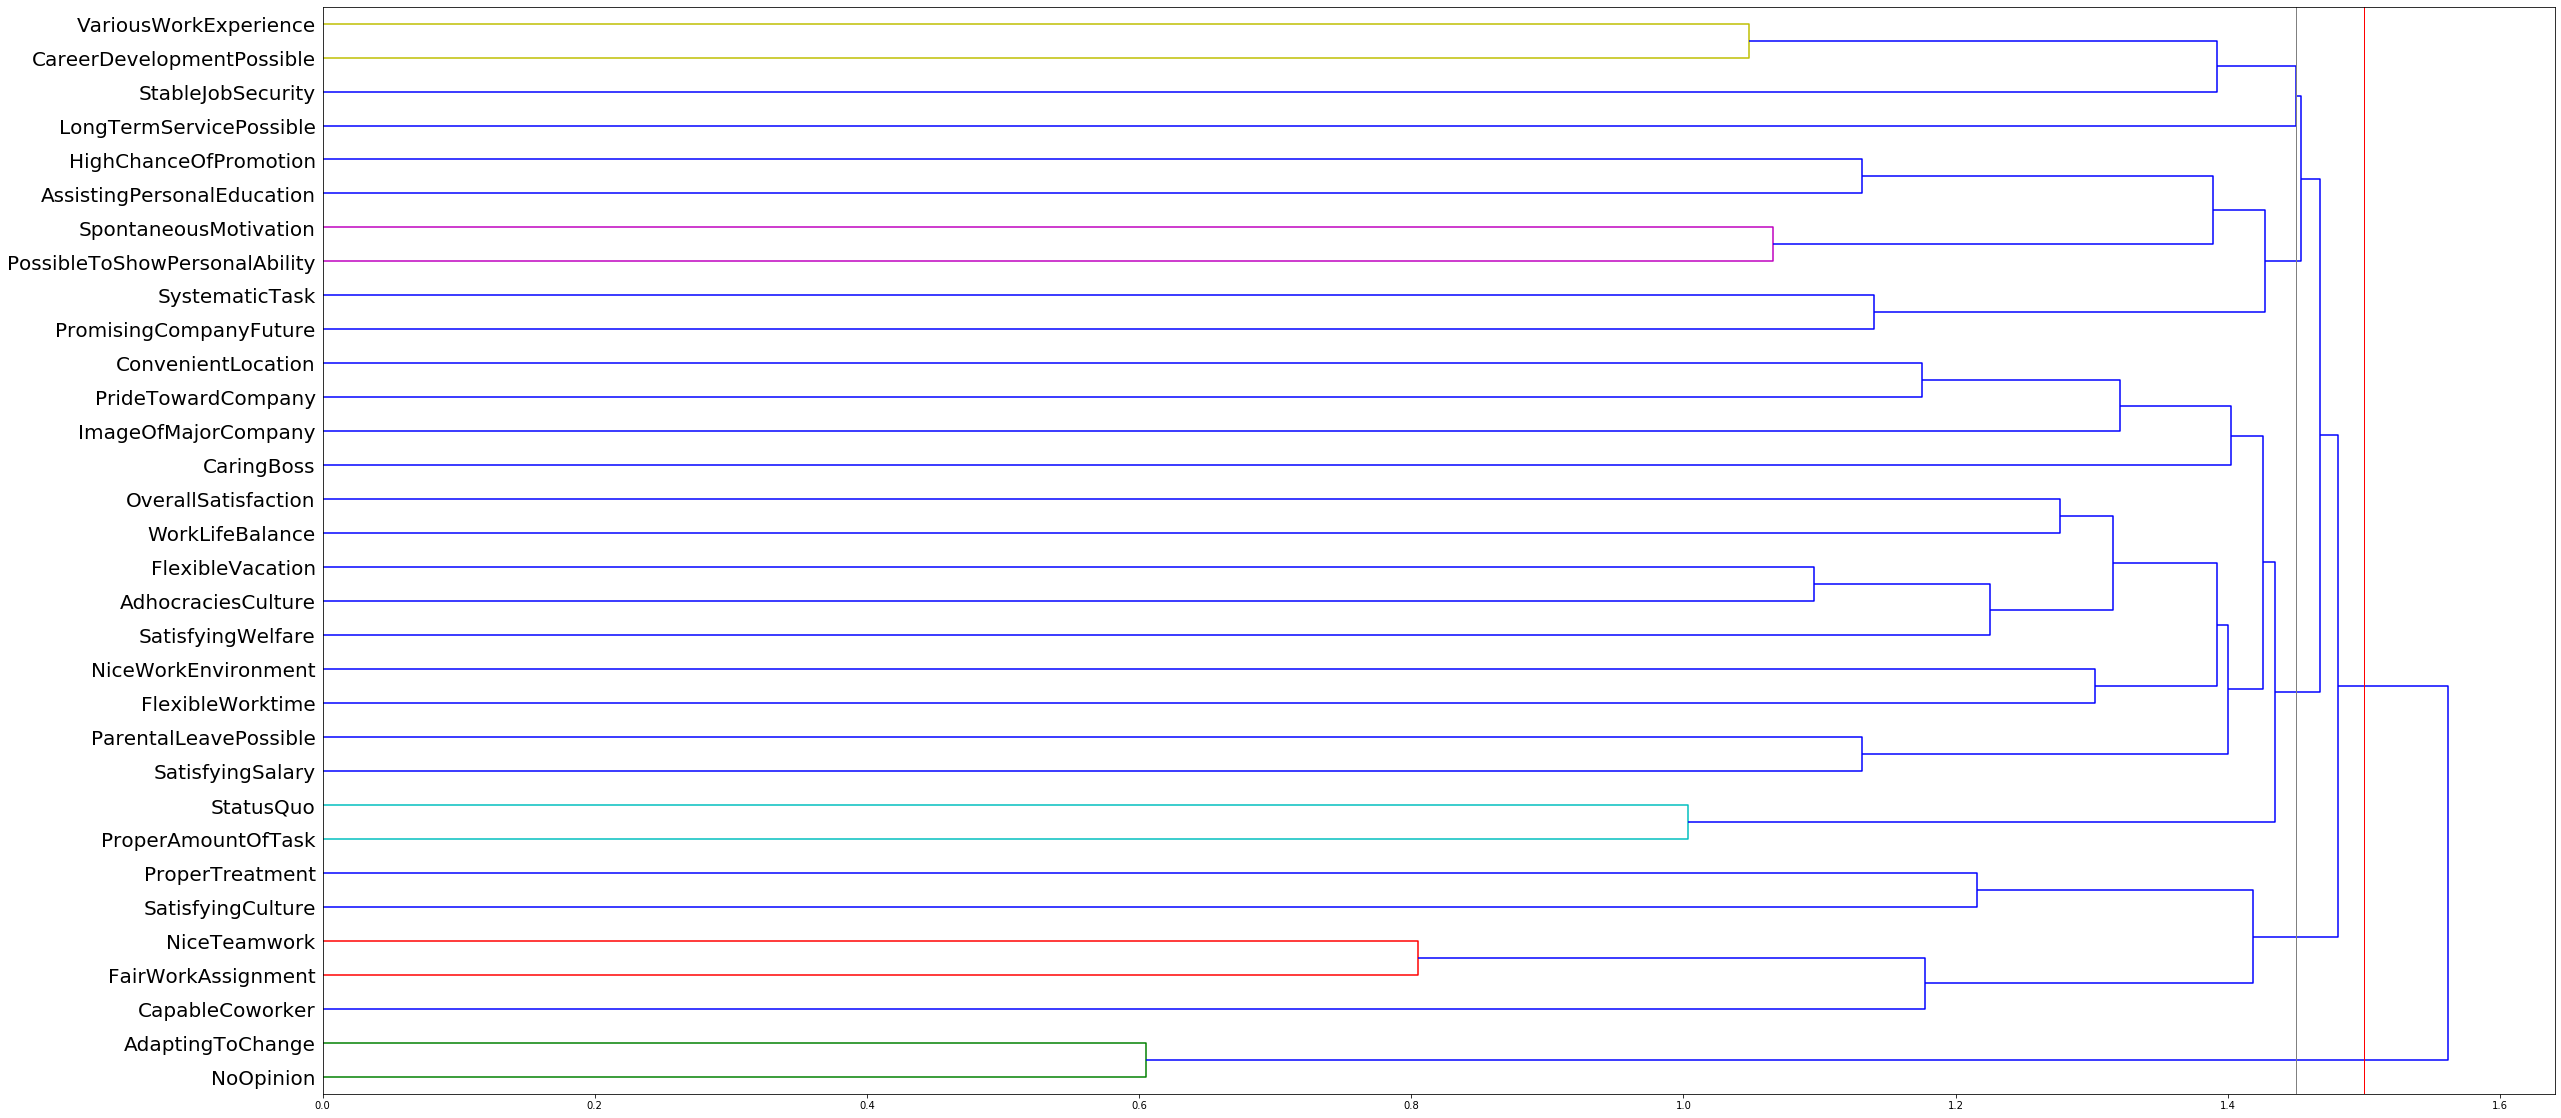

In [20]:
plt.figure(figsize=(40,20))
sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                         labels = co_occurence_matrix_df.columns, 
                                         orientation = 'right',
                                         leaf_font_size=20,
                                         show_contracted = True)
plt.axvline(x= 1.5, c='red', lw = 1)
plt.axvline(x= 1.45, c='grey', lw = 1);
##plt.savefig('lowadvantage.png');


## Interpreting the Dendrogram

(1) Clustering Standard based on 1.45 
 
 
 **Cluster 1** - VariousWorkExpereience, CareerDevelopmentPossible, StableJobSecurity, LongTermServicePossible
 
 **Cluster 2** - HighChanceOfPromotion, AssistingPersonalEducation, SpontaneousMotivation, PossibleToShowPersonalAbility, SystematicTask, PromisingCompanyFuture
 
 **Cluster 3** - ConvenientLocation, PrideTowardCompany, ImageOfMajorCompany, CaringBoss, OverallSatisfaction, WorkLifeBalance, FlexibleVacation, AdhocrasciesCulture, SatisfyingWelfare, NiceWorkEnvironment, FlexibleWorktime, ParentalLeavePossible, SatisfyingSalary, StatusQuo, ProperAmountOfTask
 
 **Cluster 4** - ProperTreatment, SatisfyingCulture, NiceTeamwork, FairWorkAssignment, CapableCoworker
 
 **Cluster 5** - AdaptingToChange, NoOpinion
 
 ### (2) -1 Calculating Average Distance Portion of Each Cluster


In [21]:
##code for calculating total distance from diagonal matrix
column_sum = [co_occurence_matrix_df.iloc[i].sum() for i in range(co_occurence_matrix_df.shape[0])]
total_distance = (sum(column_sum) - co_occurence_matrix_df.shape[0])/2


##Code Plan for Calculating Ratio
## 1. Subsetting cosine matrix for each cluster. 
## 2. Apply same code as total distance code


##For Cluster 1

cluster1_list = ['VariousWorkExperience', 'CareerDevelopmentPossible', 'StableJobSecurity', 'LongTermServicePossible']

cluster2_list = ['HighChanceOfPromotion', 'AssistingPersonalEducation', 'SpontaneousMotivation', 'PossibleToShowPersonalAbility', 'SystematicTask', 'PromisingCompanyFuture']

cluster3_list = ['ConvenientLocation', 'PrideTowardCompany', 'ImageOfMajorCompany', 'CaringBoss', 
                 'OverallSatisfaction', 'WorkLifeBalance', 'FlexibleVacation', 'AdhocraciesCulture', 'SatisfyingWelfare', 'NiceWorkEnvironment', 
                 'FlexibleWorktime', 'ParentalLeavePossible', 'SatisfyingSalary', 'StatusQuo', 'ProperAmountOfTask']

cluster4_list = ['ProperTreatment', 'SatisfyingCulture', 'NiceTeamwork', 'FairWorkAssignment', 'CapableCoworker']

cluster5_list = ['AdaptingToChange', 'NoOpinion']

c1 = co_occurence_matrix_df.copy()
c2 = co_occurence_matrix_df.copy()
c3 = co_occurence_matrix_df.copy()
c4 = co_occurence_matrix_df.copy()
c5 = co_occurence_matrix_df.copy()

In [22]:
##subset matrix for cluster 1
for i in c1.columns:
    if i not in cluster1_list:
        c1.drop(i, axis = 1, inplace = True)
        c1.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 2
for i in c2.columns:
    if i not in cluster2_list:
        c2.drop(i, axis = 1, inplace = True)
        c2.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 3
for i in c3.columns:
    if i not in cluster3_list:
        c3.drop(i, axis = 1, inplace = True)
        c3.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 4
for i in c4.columns:
    if i not in cluster4_list:
        c4.drop(i, axis = 1, inplace = True)
        c4.drop(i, axis = 0, inplace = True)
        
        
##subset matrix for cluster 5
for i in c5.columns:
    if i not in cluster5_list:
        c5.drop(i, axis = 1, inplace = True)
        c5.drop(i, axis = 0, inplace = True)

In [23]:
## Goodness of Fit for Clustering Model

c1_distance_portion = ((sum([c1.iloc[i].sum() for i in range(c1.shape[0])]) - c1.shape[0])/2)/total_distance*100
c2_distance_portion = ((sum([c2.iloc[i].sum() for i in range(c2.shape[0])]) - c2.shape[0])/2)/total_distance*100
c3_distance_portion = ((sum([c3.iloc[i].sum() for i in range(c3.shape[0])]) - c3.shape[0])/2)/total_distance*100
c4_distance_portion = ((sum([c4.iloc[i].sum() for i in range(c4.shape[0])]) - c4.shape[0])/2)/total_distance*100
c5_distance_portion = ((sum([c5.iloc[i].sum() for i in range(c5.shape[0])]) - c5.shape[0])/2)/total_distance*100

portion_list = [c1_distance_portion, c2_distance_portion, c3_distance_portion, c4_distance_portion, c5_distance_portion]


goodness_of_fit = sum(portion_list)/total_distance*100

print(goodness_of_fit)

520.999792958479


In [25]:

total_portion = [c1_distance_portion,c2_distance_portion,c3_distance_portion,c4_distance_portion,c5_distance_portion]

c1_portion = c1_distance_portion / sum(total_portion)
c2_portion = c2_distance_portion / sum(total_portion)
c3_portion = c3_distance_portion / sum(total_portion)
c4_portion = c4_distance_portion / sum(total_portion)
c5_portion = c5_distance_portion / sum(total_portion)

df = [c1_portion, c2_portion,c3_portion, c4_portion,c5_portion]
index_df = ['c1_portion', 'c2_portion', 'c3_portion', 'c4_portion', 'c5_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c1_portion,0.040020
c2_portion,0.133635
c3_portion,0.615760
c4_portion,0.148449
c5_portion,0.062136


## Report
No Meaning. Goodness of fit error

---------------------------------------------

## 3 -(4) Hierarchical Clustering Analysis for Low Drawback Total

In [31]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(low_keyword_df.drawback_total)
x_transpose = x.transpose()
cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
##Co-Occurence Matrix based on Cosine Distance
labels = vectorizer.get_feature_names()
co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
##Eliminating Needless Columns
for i in co_occurence_matrix_df.columns:
    if i not in negative:
        co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
        co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
    else:
        pass
    
##Translating Column Names into English(Korean is not allowed in dendrogram package)
eng_column = translation(co_occurence_matrix_df.columns)
co_occurence_matrix_df.columns =['ForcingMotivation', 'PossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'IrrespectfulExecutive',
       'OnlyExecutiveDecisionMaking', 'TransferOfContractWorker',
       'UnfairContractWorker', 'CustomerCommunicationProblem',
       'UnstableJobSecurity', 'BigBrotherBoss', 'OverwhelmingAmountOfTask',
       'ShiftWorkSystem', 'MonotonousWork', 'UselessCoworker',
       'NeedForCultureRenovation', 'AdaptingToChange', 'NeedToChange',
       'CulturalDifferenceByDepartment', 'TaskAmountDifferenceByDepartment',
       'UnfairWorkAssignment', 'UnsatisfyingWelfare', 'UnsatisfyingSalary',
       'UnstableCompanyFuture', 'UnresonableLaborUnion', 'UnsystematicTask',
       'UnreasonablePerformanceEvaluation', 'InproperTreatment', 'Offitics',
       'ComparativeDeprivation', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'NotWorkingEmployees',
       'ParentalLeaveImpossible', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadWorkEnvironment', 'BadTeamwork', 'FiereceCompetition',
       'NeedForAdditionalInvestment']

co_occurence_matrix_df.index =['ForcingMotivation', 'PossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'IrrespectfulExecutive',
       'OnlyExecutiveDecisionMaking', 'TransferOfContractWorker',
       'UnfairContractWorker', 'CustomerCommunicationProblem',
       'UnstableJobSecurity', 'BigBrotherBoss', 'OverwhelmingAmountOfTask',
       'ShiftWorkSystem', 'MonotonousWork', 'UselessCoworker',
       'NeedForCultureRenovation', 'AdaptingToChange', 'NeedToChange',
       'CulturalDifferenceByDepartment', 'TaskAmountDifferenceByDepartment',
       'UnfairWorkAssignment', 'UnsatisfyingWelfare', 'UnsatisfyingSalary',
       'UnstableCompanyFuture', 'UnresonableLaborUnion', 'UnsystematicTask',
       'UnreasonablePerformanceEvaluation', 'InproperTreatment', 'Offitics',
       'ComparativeDeprivation', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'NotWorkingEmployees',
       'ParentalLeaveImpossible', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadWorkEnvironment', 'BadTeamwork', 'FiereceCompetition',
       'NeedForAdditionalInvestment']

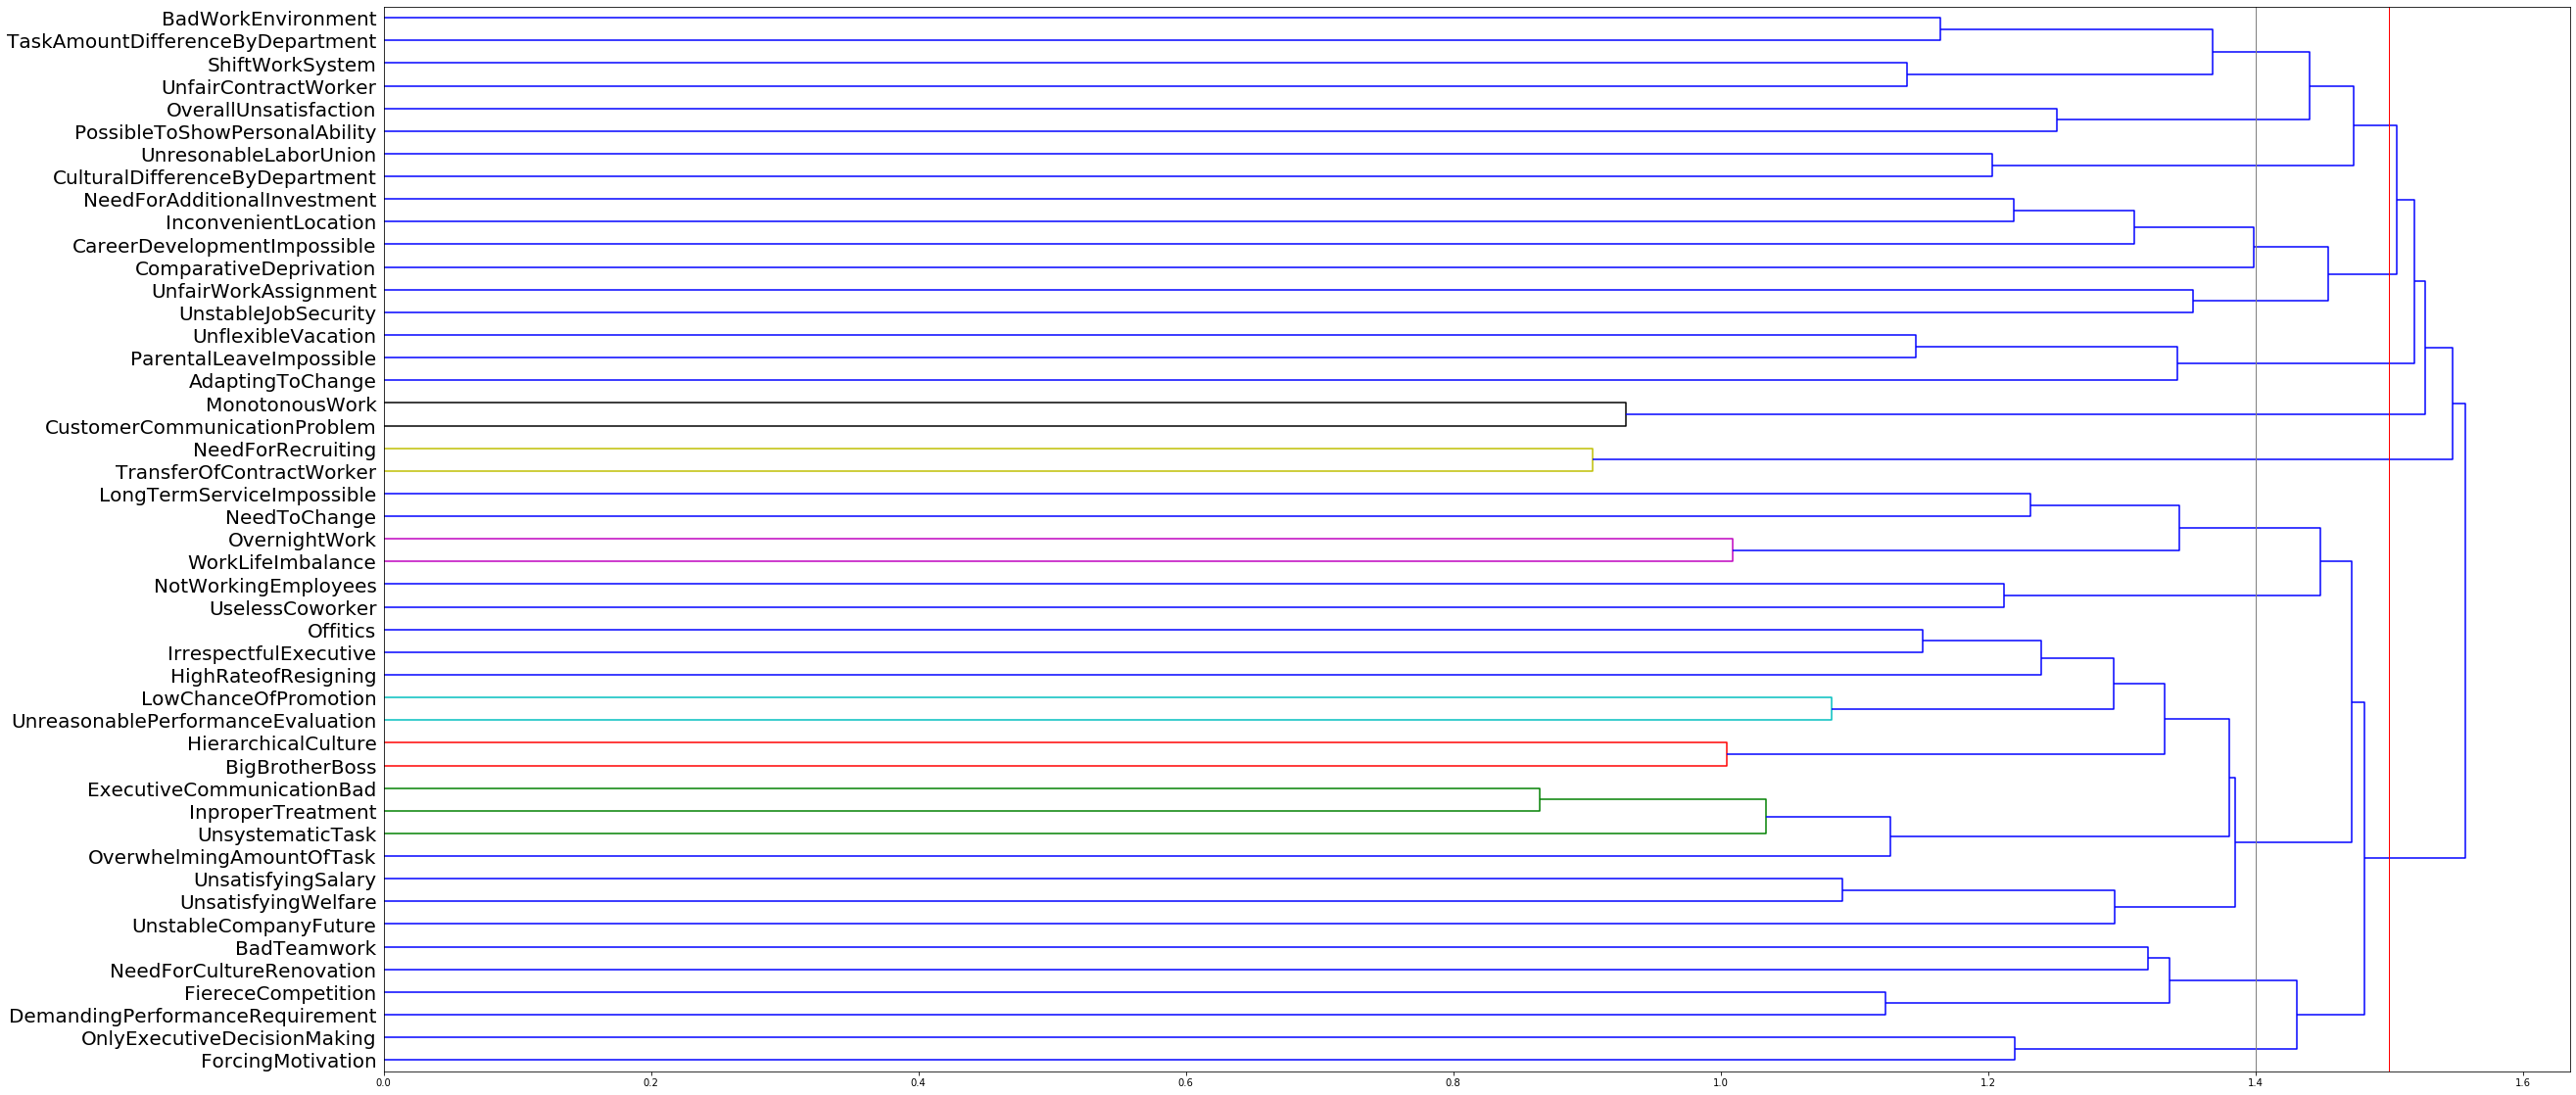

In [39]:
plt.figure(figsize=(40,20))
sch.dendrogram(sch.linkage(co_occurence_matrix_df, method='average'), 
                                             labels = co_occurence_matrix_df.columns, 
                                             orientation = 'right',
                                             leaf_font_size=20,
                                             show_contracted = True)
plt.axvline(x= 1.5, c='red', lw = 1)
plt.axvline(x= 1.4, c='grey', lw = 1)
##plt.savefig('lowdrawback.png');

## Interpreting the Dendrogram

(1) Clustering Standard based on 1.5 and 1.4 Distance. 
(2) Total Cluster could be divided into six clusters based on 1.5 distance. 

 **Cluster 1** - BadWorkEvnironment, TaskAmountDifferenceByDepartment, ShiftWorkSystem, UnfairContractWorker, OverallUnsatisfaction, PossibleToShowPersonalAbility, UnreasonableLaborUnion, CulturalDifferenceByDepartment
 
 **Cluster 2** - NeedForAdditionalInvestment, InconvenientLocation, CareerDevelopmentImpossible, ComparativeDeprivation, UnfairWorkAssignment, UnstableJobSecurity
 
 **Cluster 3** - UnflexibleVacation, ParentalLeaveImpossible, AdaptingToChange
 
 **Cluster 4** - MonotonousWork, CustomerCommunicationProblem
     
 
 **Cluster 5** - NeedforRecruiting, TransferOfContractWorker
 
 **Cluster 6** - LongTermServiceImpossible, NeedToChange, OvernightWork, WorkLifeImbalance, NotWorkingEmployees, UselessCoworker, Offitics, IrrespectfulExecutive, HighRateofResigning, LowChanceOfPromotion, UnreasonablePerformanceEvaluation, HierarchicalCulture, BigBrotherBoss, ExecutiveCommunicationBad, InproperTreatment, UnsystematicTask, OverwhelmingAmountOfTask, UnsatisfyingSalary, UnsatisfyingWelfare, UnstableCompanyFuture, BadTeamwork, NeedForCultureRenovation, FiereceCompetition, DemandingPerformanceRequirement, OnlyExecutiveDecisionMaking, ForcingMotivation
 
     Cluster 6 - 1 LongTermServiceImpossible, NeedToChange, OvernightWork, WorkLifeImbalance
     Cluster 6 - 2 NotWorkingEmployees, UselessCoworker
     Cluster 6 - 3 IrrespectfulExecutive, HighRateofResigning, LowChanceOfPromotion, UnreasonablePerformanceEvaluation, HierarchicalCulture, BigBrotherBoss, ExecutiveCommunicationBad, InproperTreatment, UnsystematicTask, OverwhelmingAmountOfTask, UnsatisfyingSalary, UnsatisfyingWelfare, UnstableCompanyFuture
     Cluster 6 - 4 BadTeamwork, NeedForCultureRenovation, FiereceCompetition, DemandingPerformanceRequirement
     Cluster 6 - 5 OnlyExecutiveDecisionMaking, ForcingMotivation
 
 
 
 ### (2) -1 Calculating Average Distance Portion of Each Cluster


In [40]:
co_occurence_matrix_df.head()

,ForcingMotivation,PossibleToShowPersonalAbility,CareerDevelopmentImpossible,IrrespectfulExecutive,OnlyExecutiveDecisionMaking,TransferOfContractWorker,UnfairContractWorker,CustomerCommunicationProblem,UnstableJobSecurity,BigBrotherBoss,...,ExecutiveCommunicationBad,InconvenientLocation,UnflexibleVacation,LongTermServiceImpossible,OvernightWork,OverallUnsatisfaction,BadWorkEnvironment,BadTeamwork,FiereceCompetition,NeedForAdditionalInvestment
ForcingMotivation,1.000000,0.00000,0.10660,0.065653,0.176777,0.000000,0.00000,0.0,0.0,0.053916,...,0.220665,0.000000,0.000000,0.000000,0.079057,0.000000,0.000000,0.000000,0.094491,0.000000
PossibleToShowPersonalAbility,0.000000,1.00000,0.13484,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,...,0.109221,0.000000,0.000000,0.000000,0.000000,0.205196,0.000000,0.000000,0.000000,0.000000
CareerDevelopmentImpossible,0.106600,0.13484,1.00000,0.000000,0.000000,0.123091,0.00000,0.0,0.0,0.137940,...,0.212729,0.174078,0.000000,0.000000,0.000000,0.069171,0.000000,0.000000,0.000000,0.128565
IrrespectfulExecutive,0.065653,0.00000,0.00000,1.000000,0.000000,0.000000,0.07581,0.0,0.0,0.141591,...,0.317462,0.000000,0.058722,0.065653,0.124568,0.085203,0.053606,0.043769,0.099258,0.039590
OnlyExecutiveDecisionMaking,0.176777,0.00000,0.00000,0.000000,1.000000,0.000000,0.00000,0.0,0.0,0.000000,...,0.162818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
##code for calculating total distance from diagonal matrix
column_sum = [co_occurence_matrix_df.iloc[i].sum() for i in range(co_occurence_matrix_df.shape[0])]
total_distance = (sum(column_sum) - co_occurence_matrix_df.shape[0])/2


##Code Plan for Calculating Ratio
## 1. Subsetting cosine matrix for each cluster. 
## 2. Apply same code as total distance code


cluster1_list = ['BadWorkEnvironment', 'TaskAmountDifferenceByDepartment', 'ShiftWorkSystem', 'UnfairContractWorker', 'OverallUnsatisfaction', 
                 'PossibleToShowPersonalAbility', 'UnreasonableLaborUnion', 'CulturalDifferenceByDepartment']

cluster2_list = ['NeedForAdditionalInvestment', 'InconvenientLocation', 'CareerDevelopmentImpossible', 
                 'ComparativeDeprivation', 'UnfairWorkAssignment', 'UnstableJobSecurity']

cluster3_list = ["UnflexibleVacation", 'ParentalLeaveImpossible', 'AdaptingToChange']


cluster4_list = ['MonotonousWork', 'CustomerCommunicationProblem']


cluster5_list = ['NeedForRecruiting', 'TransferOfContractWorker']

cluster6_list = ['LongTermServiceImpossible', 'NeedToChange', 'OvernightWork', 'WorkLifeImbalance', 
                 'NotWorkingEmployees', 'UselessCoworker', 'Offitics', "IrrespectfulExecutive", 
                 'HighRateofResigning', 'LowChanceOfPromotion', 'UnreasonablePerformanceEvaluation', 'HierarchicalCulture', 
                 'BigBrotherBoss', 'ExecutiveCommunicationBad', 'InproperTreatment', 'UnsystematicTask', 'OverwhelmingAmountOfTask', 
                 'UnsatisfyingSalary', 'UnsatisfyingWelfare', 'UnstableCompanyFuture', 'BadTeamwork', 'NeedForCultureRenovation', 
                 'FiereceCompetition', 'DemandingPerformanceRequirement', 'OnlyExecutiveDecisionMaking', 'ForcingMotivation']

c6_1_list = ['LongTermServiceImpossible', 'NeedToChange', 'OvernightWork', 'WorkLifeImbalance']
c6_2_list = ['NotWorkingEmployees', 'UselessCoworker']
c6_3_list = ['Offitics', "IrrespectfulExecutive", 'HighRateofResigning', 'LowChanceOfPromotion', 'UnreasonablePerformanceEvaluation', 'HierarchicalCulture', 
            'BigBrotherBoss', 'ExecutiveCommunicationBad', 'InproperTreatment', 'UnsystematicTask', 'OverwhelmingAmountOfTask', 
            'UnsatisfyingSalary', 'UnsatisfyingWelfare', 'UnstableCompanyFuture']
c6_4_list = ['BadTeamwork', 'NeedForCultureRenovation', 'FiereceCompetition', 'DemandingPerformanceRequirement']
c6_5_list = ['OnlyExecutiveDecisionMaking', 'ForcingMotivation']



c1 = co_occurence_matrix_df.copy()
c2 = co_occurence_matrix_df.copy()
c3 = co_occurence_matrix_df.copy()
c4 = co_occurence_matrix_df.copy()
c5 = co_occurence_matrix_df.copy()
c6 = co_occurence_matrix_df.copy()


In [43]:
##subset matrix for cluster 1
for i in c1.columns:
    if i not in cluster1_list:
        c1.drop(i, axis = 1, inplace = True)
        c1.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 2
for i in c2.columns:
    if i not in cluster2_list:
        c2.drop(i, axis = 1, inplace = True)
        c2.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 3
for i in c3.columns:
    if i not in cluster3_list:
        c3.drop(i, axis = 1, inplace = True)
        c3.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 4
for i in c4.columns:
    if i not in cluster4_list:
        c4.drop(i, axis = 1, inplace = True)
        c4.drop(i, axis = 0, inplace = True)
        
        
##subset matrix for cluster 5
for i in c5.columns:
    if i not in cluster5_list:
        c5.drop(i, axis = 1, inplace = True)
        c5.drop(i, axis = 0, inplace = True)
        
##subset matrix for cluster 6
for i in c6.columns:
    if i not in cluster6_list:
        c6.drop(i, axis = 1, inplace = True)
        c6.drop(i, axis = 0, inplace = True)

In [44]:
## Goodness of Fit for Clustering Model

c1_distance_portion = ((sum([c1.iloc[i].sum() for i in range(c1.shape[0])]) - c1.shape[0])/2)/total_distance*100
c2_distance_portion = ((sum([c2.iloc[i].sum() for i in range(c2.shape[0])]) - c2.shape[0])/2)/total_distance*100
c3_distance_portion = ((sum([c3.iloc[i].sum() for i in range(c3.shape[0])]) - c3.shape[0])/2)/total_distance*100
c4_distance_portion = ((sum([c4.iloc[i].sum() for i in range(c4.shape[0])]) - c4.shape[0])/2)/total_distance*100
c5_distance_portion = ((sum([c5.iloc[i].sum() for i in range(c5.shape[0])]) - c5.shape[0])/2)/total_distance*100
c6_distance_portion = ((sum([c6.iloc[i].sum() for i in range(c6.shape[0])]) - c6.shape[0])/2)/total_distance*100

portion_list = [c1_distance_portion, c2_distance_portion, c3_distance_portion, c4_distance_portion, c5_distance_portion, c6_distance_portion]


goodness_of_fit = sum(portion_list)/total_distance*100
print(goodness_of_fit)

99.0344566559736


In [46]:
total_portion = [c1_distance_portion,c2_distance_portion,c3_distance_portion,c4_distance_portion,c5_distance_portion,c6_distance_portion]

c1_portion = c1_distance_portion / sum(total_portion)
c2_portion = c2_distance_portion / sum(total_portion)
c3_portion = c3_distance_portion / sum(total_portion)
c4_portion = c4_distance_portion / sum(total_portion)
c5_portion = c5_distance_portion / sum(total_portion)
c6_portion = c6_distance_portion / sum(total_portion)

df = [c1_portion, c2_portion,c3_portion, c4_portion,c5_portion,c6_portion]
index_df = ['c1_portion', 'c2_portion', 'c3_portion', 'c4_portion', 'c5_portion', 'c6_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c1_portion,0.030905
c2_portion,0.026649
c3_portion,0.012682
c4_portion,0.008879
c5_portion,0.010723
c6_portion,0.910161


### Report

By ordering clusters based on their explanation power, the sequence are as follows.

c6 > c1 > c2 > c3 > c5 > c4

However, c6contains too many subsets, it does not provide useful insight. So the cluster is going to be interpreted more deeply on following section.






In [47]:
c6_1 = co_occurence_matrix_df.copy()
c6_2 = co_occurence_matrix_df.copy()
c6_3 = co_occurence_matrix_df.copy()
c6_4 = co_occurence_matrix_df.copy()
c6_5 = co_occurence_matrix_df.copy()


for i in c6_1.columns:
    if i not in c6_1_list:
        c6_1.drop(i, axis = 1, inplace = True)
        c6_1.drop(i, axis = 0, inplace = True)

for i in c6_2.columns:
    if i not in c6_2_list:
        c6_2.drop(i, axis = 1, inplace = True)
        c6_2.drop(i, axis = 0, inplace = True)

for i in c6_3.columns:
    if i not in c6_3_list:
        c6_3.drop(i, axis = 1, inplace = True)
        c6_3.drop(i, axis = 0, inplace = True)

for i in c6_4.columns:
    if i not in c6_4_list:
        c6_4.drop(i, axis = 1, inplace = True)
        c6_4.drop(i, axis = 0, inplace = True)

for i in c6_5.columns:
    if i not in c6_5_list:
        c6_5.drop(i, axis = 1, inplace = True)
        c6_5.drop(i, axis = 0, inplace = True)


        
c6_1_distance = (sum([c6_1.iloc[i].sum() for i in range(c6_1.shape[0])]) - c6_1.shape[0])/2
c6_2_distance = (sum([c6_2.iloc[i].sum() for i in range(c6_2.shape[0])]) - c6_2.shape[0])/2
c6_3_distance = (sum([c6_3.iloc[i].sum() for i in range(c6_3.shape[0])]) - c6_3.shape[0])/2
c6_4_distance = (sum([c6_4.iloc[i].sum() for i in range(c6_4.shape[0])]) - c6_4.shape[0])/2
c6_5_distance = (sum([c6_5.iloc[i].sum() for i in range(c6_5.shape[0])]) - c6_5.shape[0])/2

In [48]:
c6_1_portion = c6_1_distance / sum(total_portion)
c6_2_portion = c6_2_distance / sum(total_portion)
c6_3_portion = c6_3_distance / sum(total_portion)
c6_4_portion = c6_4_distance / sum(total_portion)
c6_5_portion = c6_4_distance / sum(total_portion)


df = [c6_1_portion, c6_2_portion, c6_3_portion, c6_4_portion, c6_5_portion]

index_df = ['c6_1_portion', 'c6_2_portion', 'c6_3_portion', 'c6_4_portion', 'c6_5_portion']

cluster_df = pd.DataFrame(df, columns = ['Proportion'], index = index_df)

cluster_df

,Proportion
c6_1_portion,0.016634
c6_2_portion,0.003483
c6_3_portion,0.277246
c6_4_portion,0.011067
c6_5_portion,0.011067


## Report

c6-3 > c6-1 > c6-4 = c6-5 > c6-2


Cluster 6 - 1 LongTermServiceImpossible, NeedToChange, OvernightWork, WorkLifeImbalance

Cluster 6 - 2 NotWorkingEmployees, UselessCoworker

**Cluster 6 - 3** IrrespectfulExecutive, HighRateofResigning, LowChanceOfPromotion, UnreasonablePerformanceEvaluation, HierarchicalCulture, BigBrotherBoss, ExecutiveCommunicationBad, InproperTreatment, UnsystematicTask, OverwhelmingAmountOfTask, UnsatisfyingSalary, UnsatisfyingWelfare, UnstableCompanyFuture

-> **"위계질서 문화, 과도한 업무량, 그리고 적절하지 않은 대우는 높은 퇴사율과 전반적 불만족도로 이어지는 것으로 추정 가능"** (27%)

Cluster 6 - 4 BadTeamwork, NeedForCultureRenovation, FiereceCompetition, DemandingPerformanceRequirement

Cluster 6 - 5 OnlyExecutiveDecisionMaking, ForcingMotivation
 

-----------------------------------------------------------------------------------------------------

## Co-occurence Matrix for Network Analysis

In [16]:
def ad_co_occurrence_matrix(corpus):
    ##Defining Distance based on Bag of Words
    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(corpus)
    x_transpose = x.transpose()
    cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
    labels = vectorizer.get_feature_names()
    co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
    for i in co_occurence_matrix_df.columns:
        if i not in positive:
            co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
            co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
        else:
            pass
    
    eng_column = translation(co_occurence_matrix_df.columns)
    co_occurence_matrix_df.columns = eng_column
    co_occurence_matrix_df.index = eng_column
    
    return(co_occurence_matrix_df)

In [17]:
def dr_co_occurrence_matrix(corpus):
    ##Defining Distance based on Bag of Words
    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(corpus)
    x_transpose = x.transpose()
    cosine_similarity = 1-pairwise_distances(x_transpose.toarray(), metric="cosine")
    
    ##Co-Occurence Matrix based on Cosine Distance
    labels = vectorizer.get_feature_names()
    co_occurence_matrix_df = pd.DataFrame(cosine_similarity, columns = labels, index = labels)
    
    ##Eliminating Needless Columns
    for i in co_occurence_matrix_df.columns:
        if i not in negative:
            co_occurence_matrix_df.drop([i], axis = 1, inplace = True)
            co_occurence_matrix_df.drop([i], axis = 0, inplace = True)
        else:
            pass
    
    eng_column = translation(co_occurence_matrix_df.columns)
    co_occurence_matrix_df.columns = eng_column
    co_occurence_matrix_df.index = eng_column
    
    return(co_occurence_matrix_df)

In [18]:
high_advantage = ad_co_occurrence_matrix(high_keyword_df.advantage_total)
high_drawback = dr_co_occurrence_matrix(high_keyword_df.drawback_total)
low_advantage = ad_co_occurrence_matrix(low_keyword_df.advantage_total)
low_drawback = dr_co_occurrence_matrix(low_keyword_df.drawback_total)

In [19]:
high_drawback.columns = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'OnlyResultMatters',
       'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking',
       'TransferOfContractWorker', 'UnfairContractWorker',
       'CustomerCommunicationProblem', 'UnstableJobSecurity', 'BigBrotherBoss',
       'OverwhelmingAmountOfTask', 'ShiftWorkSystem', 'LaborExecutiveConflict',
       'MonotonousWork', 'NeedForCultureRenovation', 'ReluctantToChange',
       'NeedToChange', 'CulturalDifferenceByDepartment',
       'TaskAmountDifferenceByDepartment', 'NegativeMarketSituation',
       'NeedForCleaningCorruption', 'UnfairWorkAssignment', 'UnsatisfyingWelfare',
       'UnsatisfyingSalary', 'UnstableCompanyFuture', 'UnresonableLaborUnion',
       'UnsystematicTask', 'UnreasonablePerformanceEvaluation', 'InproperTreatment',
       'FrequentStrike', 'Offitics', 'ComparativeDeprivation',
       'NeedForGernationChange', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'BadProductQuality',
       'NotWorkingEmployees', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation', 'UnflexibleWorktime',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadTeamwork', 'FiereceCompetition', 'NeedForAdditionalInvestment']

high_drawback.index = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'OnlyResultMatters',
       'IrrespectfulExecutive', 'OnlyExecutiveDecisionMaking',
       'TransferOfContractWorker', 'UnfairContractWorker',
       'CustomerCommunicationProblem', 'UnstableJobSecurity', 'BigBrotherBoss',
       'OverwhelmingAmountOfTask', 'ShiftWorkSystem', 'LaborExecutiveConflict',
       'MonotonousWork', 'NeedForCultureRenovation', 'ReluctantToChange',
       'NeedToChange', 'CulturalDifferenceByDepartment',
       'TaskAmountDifferenceByDepartment', 'NegativeMarketSituation',
       'NeedForCleaningCorruption', 'UnfairWorkAssignment', 'UnsatisfyingWelfare',
       'UnsatisfyingSalary', 'UnstableCompanyFuture', 'UnresonableLaborUnion',
       'UnsystematicTask', 'UnreasonablePerformanceEvaluation', 'InproperTreatment',
       'FrequentStrike', 'Offitics', 'ComparativeDeprivation',
       'NeedForGernationChange', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'BadProductQuality',
       'NotWorkingEmployees', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation', 'UnflexibleWorktime',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadTeamwork', 'FiereceCompetition', 'NeedForAdditionalInvestment']


In [20]:
low_drawback.columns = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'IrrespectfulExecutive',
       'OnlyExecutiveDecisionMaking', 'TransferOfContractWorker',
       'UnfairContractWorker', 'CustomerCommunicationProblem',
       'UnstableJobSecurity', 'BigBrotherBoss', 'OverwhelmingAmountOfTask',
       'ShiftWorkSystem', 'MonotonousWork', 'UselessCoworker',
       'NeedForCultureRenovation', 'AdaptingToChange', 'NeedToChange',
       'CulturalDifferenceByDepartment', 'TaskAmountDifferenceByDepartment',
       'UnfairWorkAssignment', 'DissatisfyingWelfare', 'DissatisfyingSalary',
       'UnstableCompanyFuture', 'UnresonableLaborUnion', 'UnsystematicTask',
       'UnreasonablePerformanceEvaluation', 'InproperTreatment', 'Offitics',
       'ComparativeDeprivation', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'NotWorkingEmployees',
       'ParentalLeaveImpossible', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadWorkEnvironment', 'BadTeamwork', 'FiereceCompetition',
       'NeedForAdditionalInvestment']

low_drawback.index = ['ForcingMotivation', 'ImpossibleToShowPersonalAbility',
       'CareerDevelopmentImpossible', 'IrrespectfulExecutive',
       'OnlyExecutiveDecisionMaking', 'TransferOfContractWorker',
       'UnfairContractWorker', 'CustomerCommunicationProblem',
       'UnstableJobSecurity', 'BigBrotherBoss', 'OverwhelmingAmountOfTask',
       'ShiftWorkSystem', 'MonotonousWork', 'UselessCoworker',
       'NeedForCultureRenovation', 'AdaptingToChange', 'NeedToChange',
       'CulturalDifferenceByDepartment', 'TaskAmountDifferenceByDepartment',
       'UnfairWorkAssignment', 'DissatisfyingWelfare', 'DissatisfyingSalary',
       'UnstableCompanyFuture', 'UnresonableLaborUnion', 'UnsystematicTask',
       'UnreasonablePerformanceEvaluation', 'InproperTreatment', 'Offitics',
       'ComparativeDeprivation', 'HierarchicalCulture', 'LowChanceOfPromotion',
       'DemandingPerformanceRequirement', 'NotWorkingEmployees',
       'ParentalLeaveImpossible', 'NeedForRecruiting', 'HighRateofResigning',
       'WorkLifeImbalance', 'ExecutiveCommunicationBad',
       'InconvenientLocation', 'UnflexibleVacation',
       'LongTermServiceImpossible', 'OvernightWork', 'OverallUnsatisfaction',
       'BadWorkEnvironment', 'BadTeamwork', 'FiereceCompetition',
       'NeedForAdditionalInvestment']

In [35]:
high_advantage.to_csv('high_advantage_co.csv')
high_drawback.to_csv('high_drawback_co.csv')
low_advantage.to_csv('low_advantage_co.csv')
low_drawback.to_csv('low_drawback_co.csv')

## Function for Calculating Centrality

In [16]:
def centrality_score(co_occurence):
    ## importing essential package
    import networkx as nx
    ##networkx method that takes co_occurence matrix as network data
    G = nx.from_pandas_adjacency(co_occurence)
    
    df1 = pd.DataFrame.from_dict(nx.degree_centrality(G), orient='index', columns = ['degree_centrality'])
    df2 = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index', columns = ['between_centrality'])
    df3 = pd.DataFrame.from_dict(nx.eigenvector_centrality(G), orient='index', columns = ['eigenvector_centrality'])
    
    centrality_df = pd.concat([df1, df2, df3], axis = 1)
    return(centrality_df)
    

In [26]:
high_ad_cen = centrality_score(high_advantage)
high_dr_cen = centrality_score(high_drawback)
low_ad_cen = centrality_score(low_advantage)
low_dr_cen = centrality_score(low_drawback)

In [27]:
high_ad_cen.sort_values(by=['eigenvector_centrality'], ascending = False).head()

,degree_centrality,between_centrality,eigenvector_centrality
SatisfyingWelfare,1.00000,0.171104,0.279549
SatisfyingSalary,0.93750,0.110912,0.272056
FlexibleWorktime,0.75000,0.020039,0.249745
AdhocraciesCulture,0.78125,0.067615,0.245261
CapableCoworker,0.78125,0.056852,0.243514


In [28]:
high_dr_cen.sort_values(by=['eigenvector_centrality'], ascending = False).head()

,degree_centrality,between_centrality,eigenvector_centrality
ExecutiveCommunicationBad,1.039216,0.162328,0.254251
UnsystematicTask,0.784314,0.035255,0.225078
HierarchicalCulture,0.803922,0.050687,0.224646
NeedForAdditionalInvestment,0.784314,0.046389,0.219968
NeedToChange,0.764706,0.042511,0.216458


In [29]:
low_ad_cen.sort_values(by=['eigenvector_centrality'], ascending = False).head()

,degree_centrality,between_centrality,eigenvector_centrality
FlexibleVacation,0.741935,0.197688,0.375096
SatisfyingWelfare,0.580645,0.058023,0.328237
ConvenientLocation,0.548387,0.102371,0.302857
WorkLifeBalance,0.580645,0.103081,0.298058
AdhocraciesCulture,0.483871,0.101525,0.245386


In [30]:
low_dr_cen.sort_values(by=['eigenvector_centrality'], ascending = False).head()

,degree_centrality,between_centrality,eigenvector_centrality
ExecutiveCommunicationBad,1.043478,0.100376,0.225664
InproperTreatment,0.956522,0.056102,0.219716
DissatisfyingSalary,0.934783,0.053022,0.217006
UnsystematicTask,0.934783,0.052035,0.216985
OverwhelmingAmountOfTask,0.869565,0.031890,0.211766


In [34]:
from IPython.display import Image

## Network Analysis of High Group's Advantage

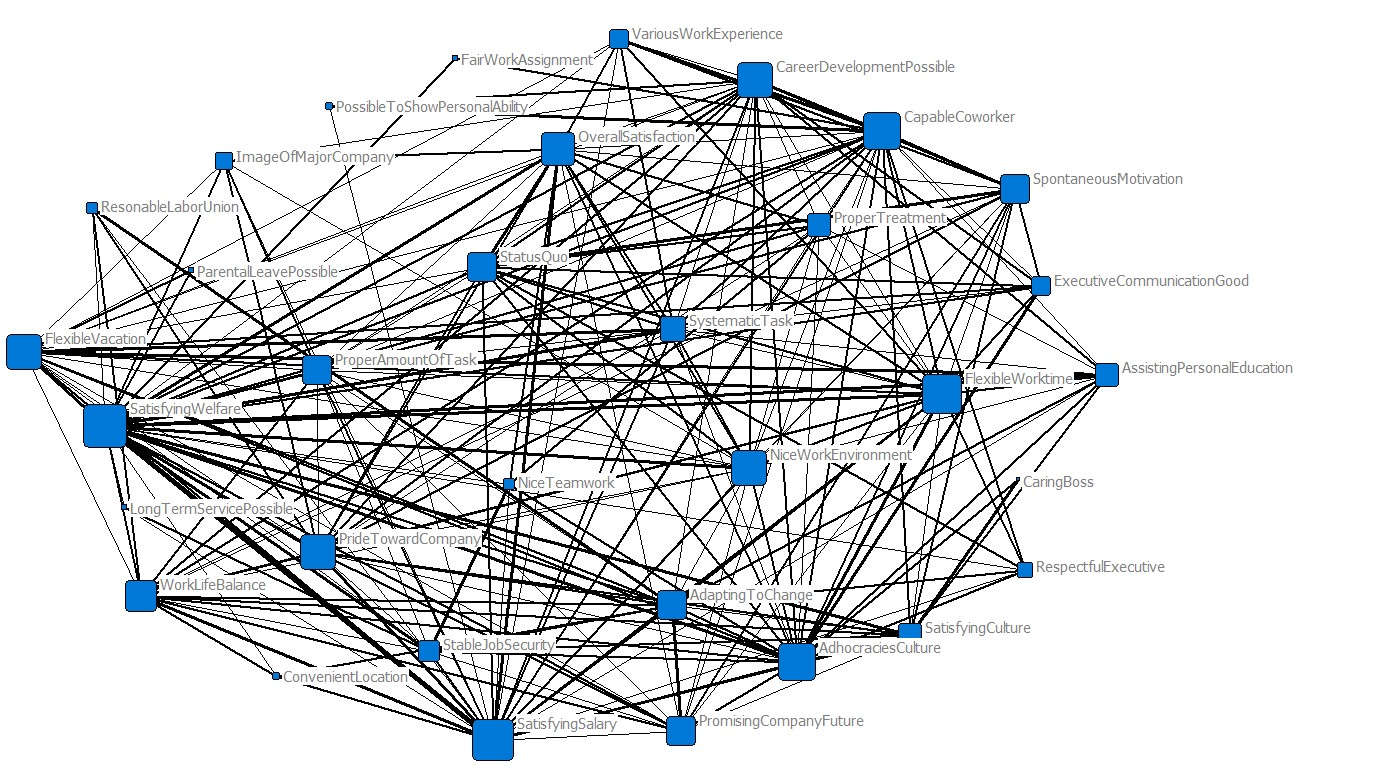

In [96]:
Image(filename='high_advantage_co.jpg')

## Network Analysis of High Group's Drawback

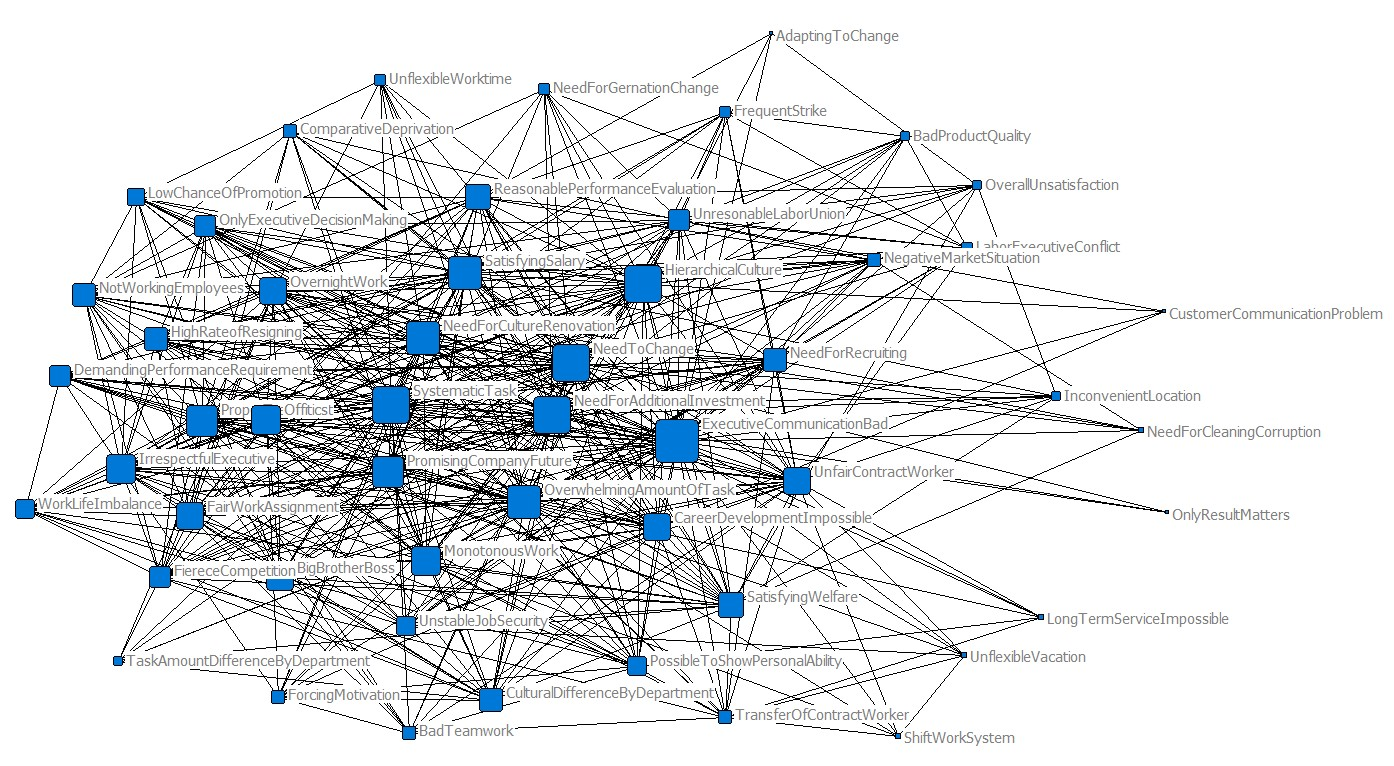

In [35]:
Image(filename='high_drawback_co.jpg')

## Network Analysis of Low Group's Advantage

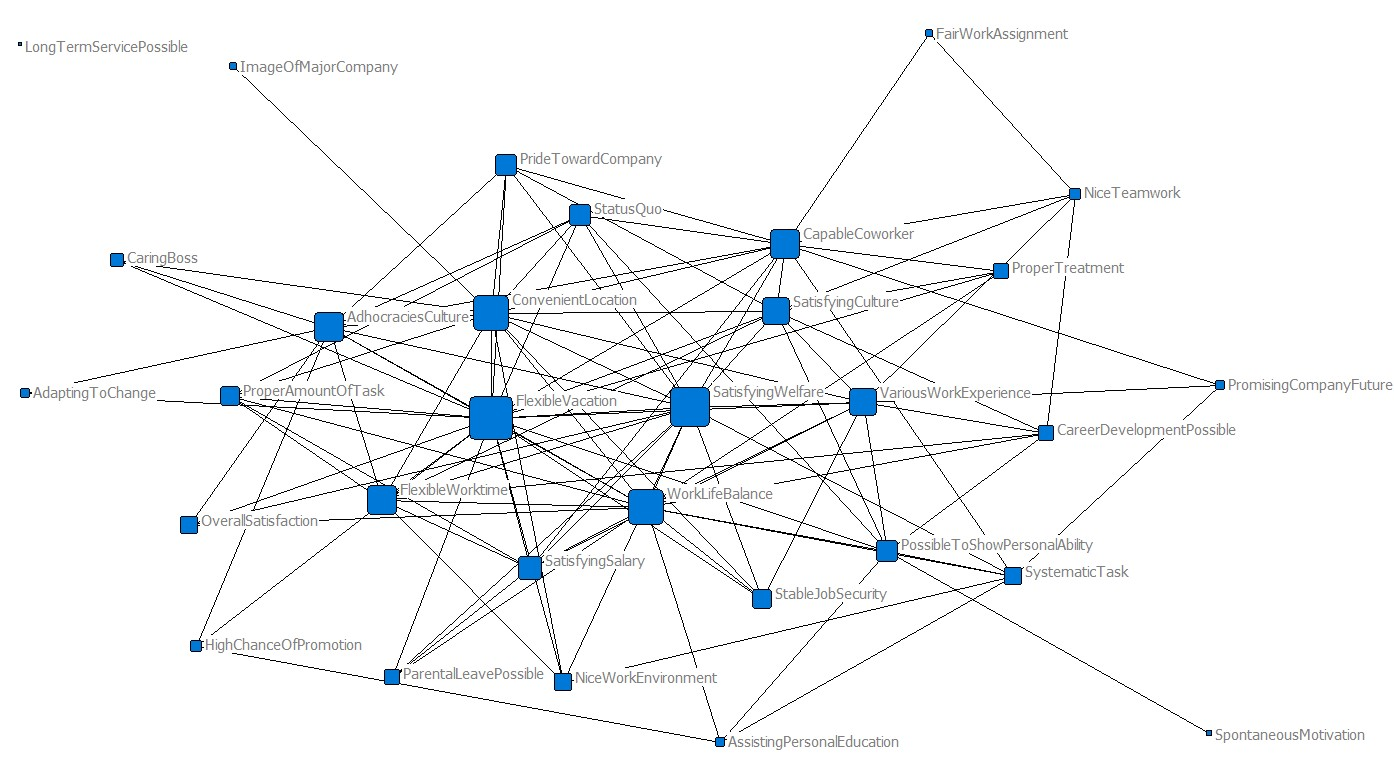

In [38]:
Image(filename='low_advantage_co.jpg')

## Network Analysis of Low Group's Drawback

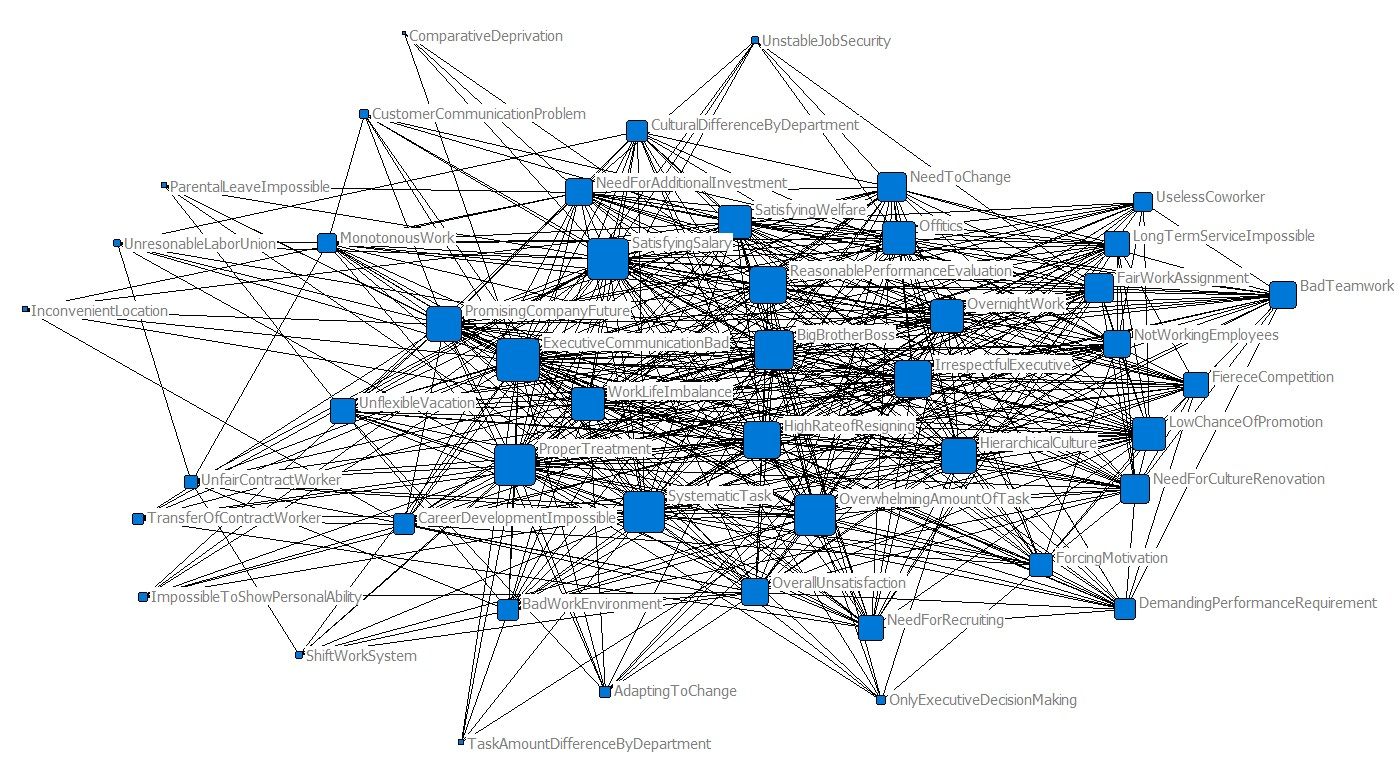

In [36]:
Image(filename='low_drawback_co.jpg')

## 분석 결론

